In [414]:
import time
import sys
import os
import random
from IPython.display import clear_output
import warnings
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import sql
import scipy.stats as stats
from scipy.stats import norm
from scipy import interp
from IPython.display import Markdown, display, HTML
import astropy.stats
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns; sns.set()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.datasets import make_imbalance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score as auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import shap

from IPython.display import clear_output
warnings.filterwarnings('ignore')

# Data understand

In [416]:
conn = psycopg2.connect(host="xxx.xxx.xxx.xxx", port="x", dbname="x", user="x", password = 'x')
cursor=conn.cursor()

In [417]:
pd.set_option('display.max_columns', None) 
rawquery="SELECT * from ml_export_180411;"
cursor.execute(rawquery)
conn.commit()
colnames = [desc[0] for desc in cursor.description]
df=pd.DataFrame(cursor.fetchall(), columns=colnames )
conn.close()
df.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [418]:
df = df.rename(columns={'default_next_month':'default'})
df = df.rename(columns={'pay_0':'pay_1'})

var_months_dict = {1:'Szept',2:'Aug',3:'Júl',4:'Jún',5:'Máj',6:'Ápr'}
var_months = [var_months_dict[k] for k in var_months_dict.keys()]

## Adatminőségi hibák feltárása

### Hiányzó értékek

In [419]:
df.isnull().sum()

id           0
limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
default      0
dtype: int64

### Feltáró statisztikák

In [420]:
pd.options.display.float_format = '{0:,.0f}'.format
display(df.describe())
df.info()
pd.options.display.float_format = '{:.0f}'.format

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,"30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000","30,000"
mean,"15,000","167,484",2,2,2,35,-0,-0,-0,-0,-0,-0,"51,223","49,179","47,013","43,263","40,311","38,872","5,664","5,921","5,226","4,826","4,799","5,216",0
std,"8,660","129,748",0,1,1,9,1,1,1,1,1,1,"73,636","71,174","69,349","64,333","60,797","59,554","16,563","23,041","17,607","15,666","15,278","17,777",0
min,1,"10,000",1,0,0,21,-2,-2,-2,-2,-2,-2,"-165,580","-69,777","-157,264","-170,000","-81,334","-339,603",0,0,0,0,0,0,0
25%,"7,501","50,000",1,1,1,28,-1,-1,-1,-1,-1,-1,"3,559","2,985","2,666","2,327","1,763","1,256","1,000",833,390,296,252,118,0
50%,"15,000","140,000",2,2,2,34,0,0,0,0,0,0,"22,382","21,200","20,088","19,052","18,104","17,071","2,100","2,009","1,800","1,500","1,500","1,500",0
75%,"22,500","240,000",2,2,2,41,0,0,0,0,0,0,"67,091","64,006","60,165","54,506","50,190","49,198","5,006","5,000","4,505","4,013","4,032","4,000",0
max,"30,000","1,000,000",2,6,3,79,8,8,8,8,8,8,"964,511","983,931","1,664,089","891,586","927,171","961,664","873,552","1,684,259","896,040","621,000","426,529","528,666",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
id           30000 non-null int64
limit_bal    30000 non-null int64
sex          30000 non-null int64
education    30000 non-null int64
marriage     30000 non-null int64
age          30000 non-null int64
pay_1        30000 non-null int64
pay_2        30000 non-null int64
pay_3        30000 non-null int64
pay_4        30000 non-null int64
pay_5        30000 non-null int64
pay_6        30000 non-null int64
bill_amt1    30000 non-null int64
bill_amt2    30000 non-null int64
bill_amt3    30000 non-null int64
bill_amt4    30000 non-null int64
bill_amt5    30000 non-null int64
bill_amt6    30000 non-null int64
pay_amt1     30000 non-null int64
pay_amt2     30000 non-null int64
pay_amt3     30000 non-null int64
pay_amt4     30000 non-null int64
pay_amt5     30000 non-null int64
pay_amt6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


### Elkódolt értékek tisztázása - ismert adathibák

In [421]:
dictedu = {0:4,1:1,2:2,3:3,4:4,5:4,6:4}
df['education'] = df['education'].map(dictedu)
df['education'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: education, dtype: int64

In [422]:
dictmarr = {0:3,1:1,2:2,3:3}
df['marriage'] = df['marriage'].map(dictmarr)
df['marriage'].value_counts()

2    15964
1    13659
3      377
Name: marriage, dtype: int64

### Kiugró értékek kezelése

#### Kiugró értékek arányának megh.

In [423]:
colout = ['age','limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
          'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

In [424]:
pd.options.display.float_format = '{:.2f}'.format
eloszlas1 = pd.DataFrame()
eloszlas1['$\mu$'] = df.loc[:,colout].mean()
eloszlas1["$\sigma$"] = df.loc[:,colout].std()
for valt in eloszlas1.index:
    std = df[valt].std()
    mean = df[valt].mean()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std) \
        & (df[valt]<=mean+std)][valt].count()/df[valt].count()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+2\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std*2) \
        & (df[valt]<=mean+std*2)][valt].count()/df[valt].count()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+3\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std*3) \
        & (df[valt]<=mean+std*3)][valt].count()/df[valt].count()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+4\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std*4) \
        & (df[valt]<=mean+std*4)][valt].count()/df[valt].count()
eloszlas1

,$\mu$,$\sigma$,$\frac{\sum n_{i\le\mu+\sigma}}{\sum n}$,$\frac{\sum n_{i\le\mu+2\sigma}}{\sum n}$,$\frac{\sum n_{i\le\mu+3\sigma}}{\sum n}$,$\frac{\sum n_{i\le\mu+4\sigma}}{\sum n}$
age,35.49,9.22,0.65,0.96,1.00,1.00
limit_bal,167484.32,129747.66,0.69,0.95,1.00,1.00
bill_amt1,51223.33,73635.86,0.88,0.95,0.98,0.99
bill_amt2,49179.08,71173.77,0.88,0.95,0.98,0.99
bill_amt3,47013.15,69349.39,0.88,0.95,0.98,0.99
bill_amt4,43262.95,64332.86,0.88,0.95,0.98,0.99
bill_amt5,40311.40,60797.16,0.88,0.95,0.98,0.99
bill_amt6,38871.76,59554.11,0.88,0.95,0.98,0.99
pay_amt1,5663.58,16563.28,0.96,0.98,0.99,0.99
pay_amt2,5921.16,23040.87,0.97,0.99,0.99,0.99


#### Kiugró értékek helyettesítése a szélső értékekkel

In [425]:
pd.options.display.float_format = '{:,.2f}'.format
eloszlas1 = pd.DataFrame()
eloszlas1['$\mu$'] = df.loc[:,colout].mean()
eloszlas1["$\sigma$"] = df.loc[:,colout].std()

In [426]:
for var in colout:
    for ll in df["default"].unique():
        coldefmean = round(df[df["default"] == ll][var].mean(),0)
        coldefstd = round(df[df["default"] == ll][var].std(),0)
        df.loc[(df["default"] == ll) & (df[var] <= coldefmean - coldefstd * 2),var] = round(coldefmean - coldefstd * 2,0)
        df.loc[(df["default"] == ll) & (df[var] >= coldefmean + coldefstd * 2),var] = round(coldefmean + coldefstd * 2,0)

In [427]:
for valt in eloszlas1.index:
    mean = eloszlas1.loc[valt,'$\mu$']
    std =  eloszlas1.loc[valt,"$\sigma$"]
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std) \
        & (df[valt]<=mean+std)][valt].count()/df[valt].count()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+2\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std*2) \
        & (df[valt]<=mean+std*2)][valt].count()/df[valt].count()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+3\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std*3) \
        & (df[valt]<=mean+std*3)][valt].count()/df[valt].count()
    eloszlas1.loc[valt,r"$\frac{\sum n_{i\le\mu+4\sigma}}{\sum n}$"] = df[(df[valt]>=mean-std*4) \
        & (df[valt]<=mean+std*4)][valt].count()/df[valt].count()
eloszlas1

,$\mu$,$\sigma$,$\frac{\sum n_{i\le\mu+\sigma}}{\sum n}$,$\frac{\sum n_{i\le\mu+2\sigma}}{\sum n}$,$\frac{\sum n_{i\le\mu+3\sigma}}{\sum n}$,$\frac{\sum n_{i\le\mu+4\sigma}}{\sum n}$
age,35.49,9.22,0.65,0.99,1.00,1.00
limit_bal,"167,484.32","129,747.66",0.69,0.95,1.00,1.00
bill_amt1,"51,223.33","73,635.86",0.88,0.96,1.00,1.00
bill_amt2,"49,179.08","71,173.77",0.88,0.96,1.00,1.00
bill_amt3,"47,013.15","69,349.39",0.88,0.96,1.00,1.00
bill_amt4,"43,262.95","64,332.86",0.88,0.96,1.00,1.00
bill_amt5,"40,311.40","60,797.16",0.88,0.99,1.00,1.00
bill_amt6,"38,871.76","59,554.11",0.88,0.96,1.00,1.00
pay_amt1,"5,663.58","16,563.28",0.96,0.98,1.00,1.00
pay_amt2,"5,921.16","23,040.87",0.97,0.99,1.00,1.00


## Változók elemzése

#### Kategória változók

##### Fizetésképtelenség a következő hónapban - célváltozó

In [431]:
dfdefa = pd.DataFrame()
dfdefa['FizKépt'] = df['default'].value_counts()
dfdefa = dfdefa.rename(index={0: 'Fizetőképes',1: 'Fizetésképtelen'})
dfdefa['%'] = ( dfdefa['FizKépt'] / dfdefa['FizKépt'].sum() ) * 100
display('Fizetésképtelenség az adathalmazban')
dfdefa

'Fizetésképtelenség az adathalmazban'

,FizKépt,%
Fizetőképes,23364,77.88
Fizetésképtelen,6636,22.12


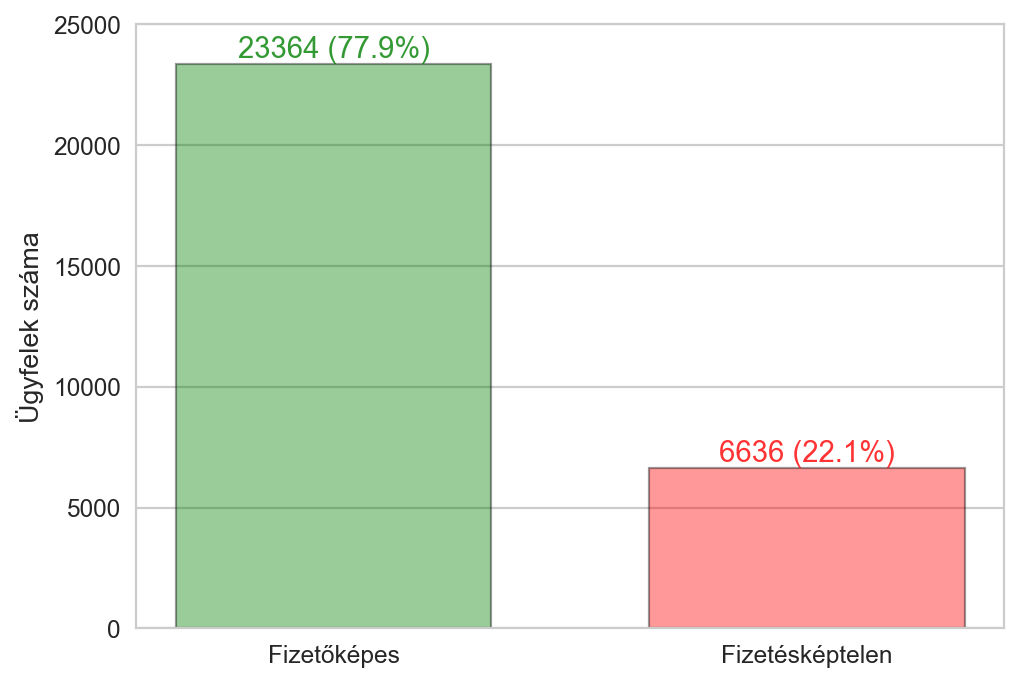

In [651]:
width = 0.4
N = 1
ind = np.arange(N)
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 160
t_clrp = sns.color_palette()[0:]
fig = plt.figure()
sns.set(font_scale=1.1)
sns.set_style("whitegrid",{'legend.frameon':True})
ax = fig.add_subplot(111)

yvals = [dfdefa['FizKépt'][0]]
rects1 = ax.bar(0.5, yvals, width, color='g', alpha=0.4, edgecolor='black', linewidth=1)
zvals = [dfdefa['FizKépt'][1]]
rects2 = ax.bar(1.1, zvals, width, color='r', alpha=0.4, edgecolor='black', linewidth=1)

ax.set_ylabel('Ügyfelek száma')
ax.set_xticks([0.5,1.1])
ax.set_xticklabels( ('Fizetőképes', 'Fizetésképtelen') )
#ax.legend( (rects1[0], rects2[0]), ('Fizetőképes', 'Fizetésképtelen') )
ax.set_ylim(top=25000,bottom=0)
ax.xaxis.grid()


def autolabel(rects,color):
    for rect in range(len(rects)):
        h = rects[rect].get_height()
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+30, '{} ({:.1f}%)'.format(h,h/dfdefa['FizKépt'].sum()*100),
                ha='center', va='bottom', alpha=0.8,color=color)

autolabel(rects1,'g')
autolabel(rects2,'r')

In [108]:
default_rat_targ = {0: 0.5, 1: 0.5}

##### Legmagasabb iskolai végzettség

In [109]:
dfedu = pd.DataFrame()
dfedu['IskVégz'] = df['education'].replace({1:'Másoddiploma',2:'Felsőoktatás',3:'Érettségi',4:'Egyéb'}).value_counts()
dfedu['%'] = ( dfedu['IskVégz'] / dfedu['IskVégz'].sum() ) * 100
display('Legmagasabb iskolai végzettség aránya az adathalmazban')
dfedu

'Legmagasabb iskolai végzettség aránya az adathalmazban'

,IskVégz,%
Felsőoktatás,14030,46.77
Másoddiploma,10585,35.28
Érettségi,4917,16.39
Egyéb,468,1.56


In [661]:
dfedu = pd.DataFrame()
dfedu['IskVégz'] = df.education.replace({1:'Posztgraduális',2:'Alapképzés',3:'Középfokú',4:'Egyéb'})
dfedu['FizKépt'] = df.default.replace({0: 'Nem',1: 'Igen'})
dfedu = dfedu.groupby(['IskVégz','FizKépt']).size().unstack()
dfedu_index = dfedu.index.values
dfedu_colu = dfedu.columns.values
dfedu = pd.DataFrame(dfedu.loc[:,:].values)
dfedu.index = dfedu_index
dfedu.columns = dfedu_colu
dfedu.sort_values(by='Igen',ascending=False,inplace=True)
dfedu['%'] = ( dfedu['Igen'] / dfedu.sum(axis=1) ) * 100

In [662]:
dfedu

,Igen,Nem,%
Alapképzés,3330,10700,23.73
Posztgraduális,2036,8549,19.23
Középfokú,1237,3680,25.16
Egyéb,33,435,7.05


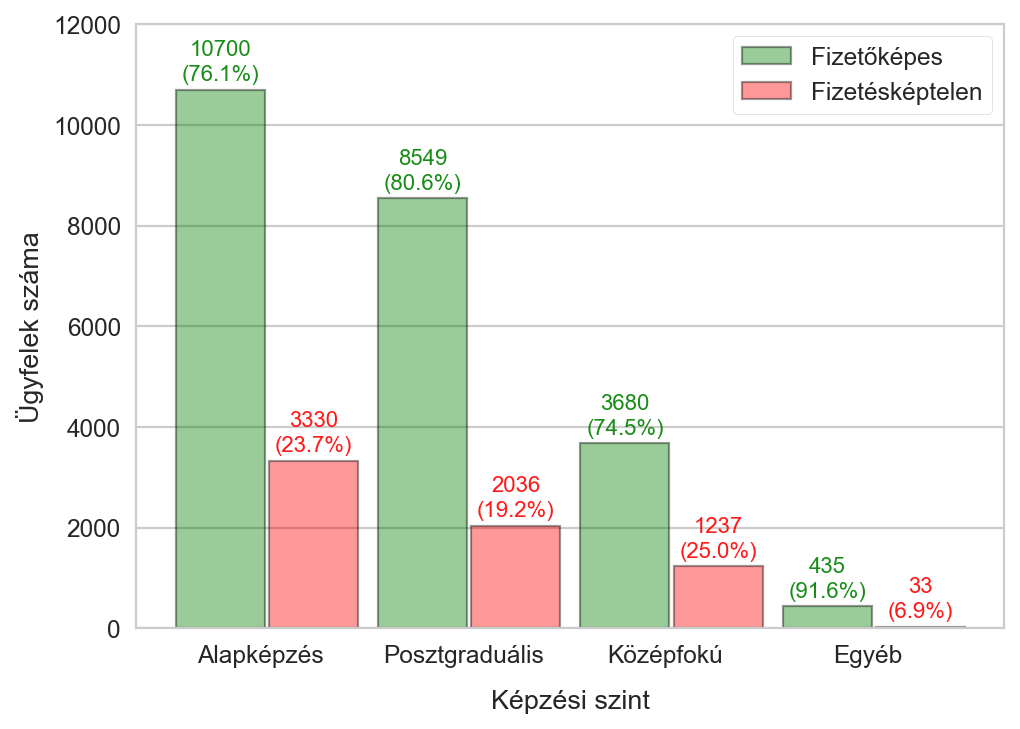

In [707]:
width = 0.44
N = 4
ind = np.arange(N)
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 160
t_clrp = sns.color_palette()[0:]
fig = plt.figure()
sns.set(font_scale=1.1)
sns.set_style("whitegrid",{'legend.frameon':True})
ax = fig.add_subplot(111)

yvals = [dfedu['Nem'][0], dfedu['Nem'][1],dfedu['Nem'][2],dfedu['Nem'][3]]
rects1 = ax.bar(ind, yvals, width, color='g', alpha=0.4, edgecolor='black', linewidth=1)
zvals = [dfedu['Igen'][0], dfedu['Igen'][1],dfedu['Igen'][2],dfedu['Igen'][3]]
rects2 = ax.bar(ind+width+0.02, zvals, width, color='r', alpha=0.4, edgecolor='black', linewidth=1)

ax.set_ylabel('Ügyfelek száma')
ax.set_xticks(ind+0.20)
ax.set_xticklabels( (dfedu.index[0], dfedu.index[1], dfedu.index[2], dfedu.index[3]) )
ax.legend( (rects1[0], rects2[0]), ('Fizetőképes', 'Fizetésképtelen') )
ax.set_ylim(top=12000,bottom=0)
ax.xaxis.grid()
ax.set(xlabel='Képzési szint')
ax.xaxis.labelpad = 10

def autolabel(rects,color,column):
    for rect in range(len(rects)):
        h = rects[rect].get_height()
        indexn = dfedu.index
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+600, '{}'.format(h),
                ha='center', va='bottom', alpha=0.9,color=color, fontsize=10)
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+100, '({:.1f}%)'.format(h/dfedu.loc[indexn[rect],:].sum()*100),
                ha='center', va='bottom', alpha=0.9,color=color, fontsize=10)

autolabel(rects1,'g','Igen')
autolabel(rects2,'r','Nem')

##### Családi állapot

In [111]:
df['marriage'].value_counts()

2    15964
1    13659
3      377
Name: marriage, dtype: int64

In [631]:
dfmarr = pd.DataFrame()
dfmarr['CsalÁll'] = df['marriage'].replace({1:'Házas',2:'Nőtlen/Hajadon',3:'Elvált',0:'Egyéb'}).value_counts()
dfmarr['%'] = ( dfmarr['CsalÁll'] / dfmarr['CsalÁll'].sum() ) * 100

In [633]:
dfmarr = pd.DataFrame()
dfmarr['CsalÁll'] = df.marriage.replace({1:'Házas',2:'Egyedülálló',3:'Elvált',0:'Egyéb'})
dfmarr['FizKépt'] = df.default.replace({0: 'Nem',1: 'Igen'})
dfmarr = dfmarr.groupby(['CsalÁll','FizKépt']).size().unstack()
dfmarr_index = dfmarr.index.values
dfmarr_colu = dfmarr.columns.values
dfmarr = pd.DataFrame(dfmarr.loc[:,:].values)
dfmarr.index = dfmarr_index
dfmarr.columns = dfmarr_colu
dfmarr.sort_values(by='Igen',ascending=False,inplace=True)
dfmarr['%'] = ( dfmarr['Igen'] / dfmarr.sum(axis=1) ) * 100

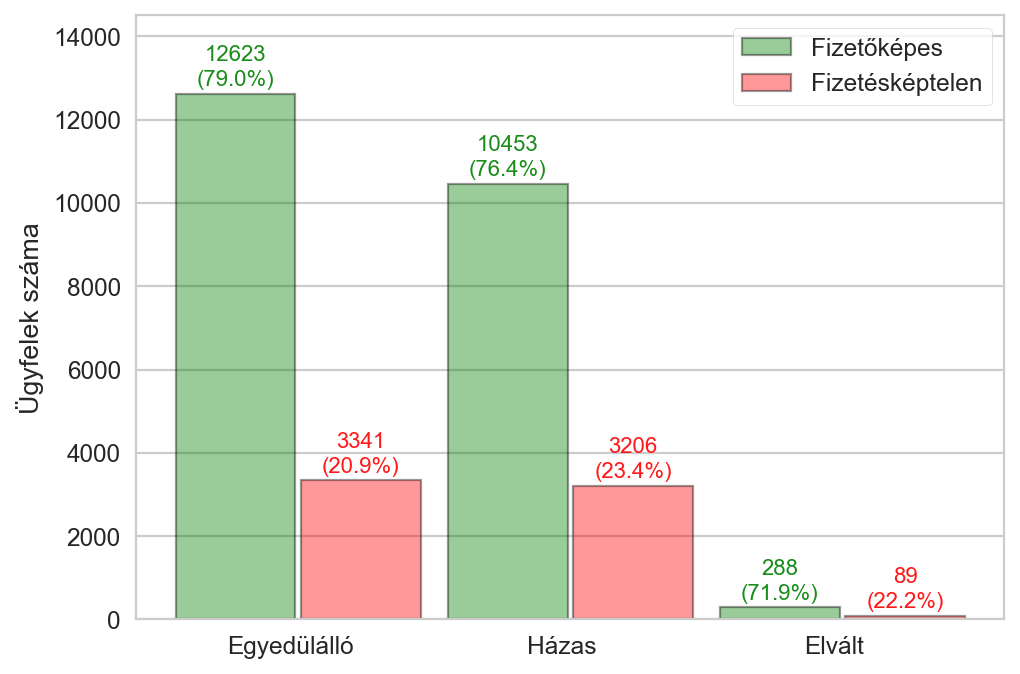

In [706]:
width = 0.44
N = 3
ind = np.arange(N)
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 160
t_clrp = sns.color_palette()[0:]
fig = plt.figure()
sns.set(font_scale=1.1)
sns.set_style("whitegrid",{'legend.frameon':True})
ax = fig.add_subplot(111)

yvals = [dfmarr['Nem'][0], dfmarr['Nem'][1],dfmarr['Nem'][2]]
rects1 = ax.bar(ind, yvals, width, color='g', alpha=0.4, edgecolor='black', linewidth=1)
zvals = [dfmarr['Igen'][0], dfmarr['Igen'][1],dfmarr['Igen'][2]]
rects2 = ax.bar(ind+width+0.02, zvals, width, color='r', alpha=0.4, edgecolor='black', linewidth=1)

ax.set_ylabel('Ügyfelek száma')
ax.set_xticks(ind+0.20)
ax.set_xticklabels( (dfmarr.index[0], dfmarr.index[1], dfmarr.index[2]) )
ax.legend( (rects1[0], rects2[0]), ('Fizetőképes', 'Fizetésképtelen') )
ax.set_ylim(top=14500,bottom=0)
ax.xaxis.grid()


def autolabel(rects,color,column):
    for rect in range(len(rects)):
        h = rects[rect].get_height()
        indexn = dfmarr.index
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+700, '{}'.format(h),
                ha='center', va='bottom', alpha=0.9,color=color, fontsize=10)
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+100, '({:.1f}%)'.format(h/dfmarr.loc[indexn[rect],:].sum()*100),
                ha='center', va='bottom', alpha=0.9,color=color, fontsize=10)

autolabel(rects1,'g','Igen')
autolabel(rects2,'r','Nem')

##### Nemek

In [114]:
df['sex'].replace({1:'FF',2:'NŐ'}).value_counts()

NŐ    18112
FF    11888
Name: sex, dtype: int64

In [115]:
dfsex = pd.DataFrame()
dfsex['Fő'] = df['sex'].replace({1:'Férfi',2:'Nő'}).value_counts()
dfsex['%'] = (dfsex['Fő'] / dfsex['Fő'].sum()) * 100
dfsex

,Fő,%
Nő,18112,60.37
Férfi,11888,39.63


In [672]:
dfsex = pd.DataFrame()
dfsex['Nemek'] = df['sex'].replace({1:'Férfi',2:'Nő'})
dfsex['FizKépt'] = df.default.replace({0: 'Nem',1: 'Igen'})
dfsex = dfsex.groupby(['Nemek','FizKépt']).size().unstack()
dfsex_index = dfsex.index.values
dfsex_colu = dfsex.columns.values
dfsex = pd.DataFrame(dfsex.loc[:,:].values)
dfsex.index = dfsex_index
dfsex.columns = dfsex_colu
dfsex.sort_values(by='Igen',ascending=False,inplace=True)
dfsex['%'] = ( dfsex['Igen'] / dfsex.sum(axis=1) ) * 100

In [673]:
dfsex

,Igen,Nem,%
Nő,3763,14349,20.78
Férfi,2873,9015,24.17


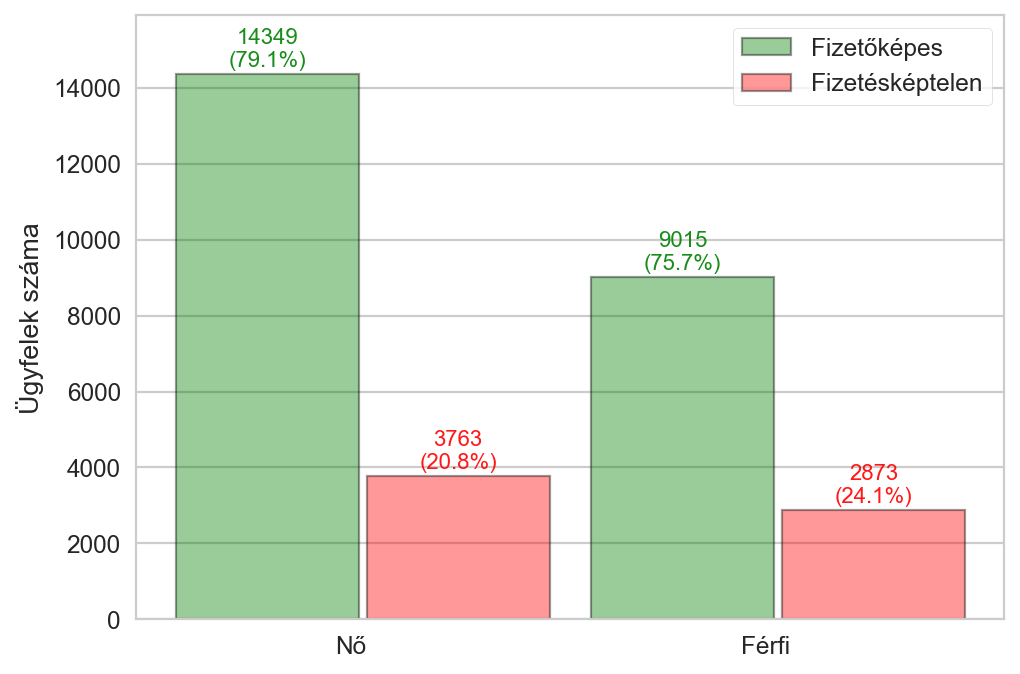

In [682]:
width = 0.44
N = 2
ind = np.arange(N)
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 160
t_clrp = sns.color_palette()[0:]
fig = plt.figure()
sns.set(font_scale=1.1)
sns.set_style("whitegrid",{'legend.frameon':True})
ax = fig.add_subplot(111)

yvals = [dfsex['Nem'][0], dfsex['Nem'][1]]
rects1 = ax.bar(ind, yvals, width, color='g', alpha=0.4, edgecolor='black', linewidth=1)
zvals = [dfsex['Igen'][0], dfsex['Igen'][1]]
rects2 = ax.bar(ind+width+0.02, zvals, width, color='r', alpha=0.4, edgecolor='black', linewidth=1)

ax.set_ylabel('Ügyfelek száma')
ax.set_xticks(ind+0.20)
ax.set_xticklabels( (dfsex.index[0], dfsex.index[1] ) )
ax.legend( (rects1[0], rects2[0]), ('Fizetőképes', 'Fizetésképtelen') )
ax.set_ylim(top=15900,bottom=0)
ax.xaxis.grid()


def autolabel(rects,color,column):
    for rect in range(len(rects)):
        h = rects[rect].get_height()
        indexn = dfsex.index
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+700, '{}'.format(h),
                ha='center', va='bottom', alpha=0.9,color=color, fontsize=10)
        ax.text(rects[rect].get_x()+rects[rect].get_width()/2., h+100, '({:.1f}%)'.format(h/dfsex.loc[indexn[rect],:].sum()*100),
                ha='center', va='bottom', alpha=0.9,color=color, fontsize=10)

autolabel(rects1,'g','Igen')
autolabel(rects2,'r','Nem')

#### Folytonos értékkészletű változók 

In [117]:
#ID
#Ismétlődés
sum(df['id'].value_counts() > 1)

0

##### Hitelkeret - Limit balance

In [118]:
#Hitelkeret
pd.options.display.float_format = '{:,.2f}'.format
dflim = pd.DataFrame()
dflim['Hitelkeret'] = df['limit_bal'].copy()

In [119]:
dstat = pd.DataFrame()
dstat.loc['Hitelkeret','Átlag'] = dflim.Hitelkeret.mean()
dstat.loc['Hitelkeret','Medián'] = dflim.Hitelkeret.median()
dstat.loc['Hitelkeret','Módusz'] = dflim.Hitelkeret.mode()[0]
dstat.loc['Hitelkeret','Minimum'] = dflim.Hitelkeret.min()
dstat.loc['Hitelkeret','Maximum'] = dflim.Hitelkeret.max()
dstat.loc['Hitelkeret','Ferdeség'] = dflim.Hitelkeret.skew()
dstat.loc['Hitelkeret','Csúcsosság'] = dflim.Hitelkeret.kurtosis()
#D’Agostino and Pea
_, dstat.loc['Hitelkeret','Normteszt'] = stats.normaltest(dflim.Hitelkeret)
dstat 

,Átlag,Medián,Módusz,Minimum,Maximum,Ferdeség,Csúcsosság,Normteszt
Hitelkeret,"163,990.96","140,000.00","50,000.00","10,000.00","441,356.00",0.72,-0.49,0.00


In [120]:
pd.options.display.float_format = '{:,.0f}'.format
dflim['Decilis'] = pd.qcut(df['limit_bal'], 10, labels=False)
dflim_dec = dflim.groupby('Decilis')['Hitelkeret',].mean().T
dflim_dec.index = ['Hitelkeret']
dflim_dec

Decilis,0,1,2,3,4,5,6,7,8,9
Hitelkeret,"22,735","49,360","64,698","88,411","125,870","164,239","202,014","241,469","321,231","416,866"


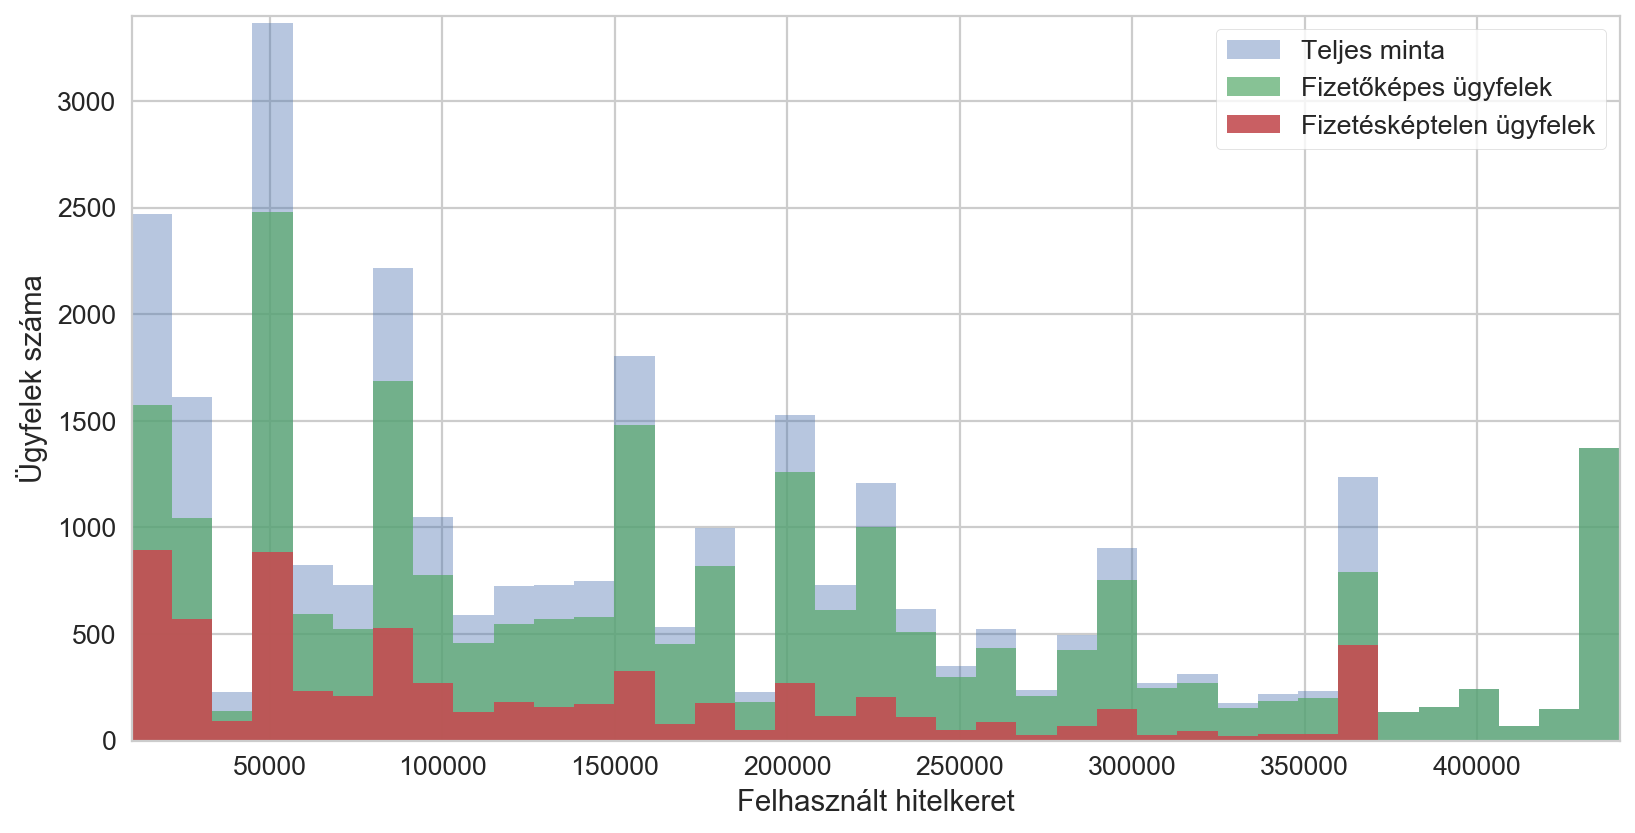

In [717]:
dflim['nemek'] = df.sex.copy()
dflim['FizKépt'] = df.default.copy()
_,dflim_bins = astropy.stats.histogram(dflim.Hitelkeret,bins='knuth')
dflim['bins'] = pd.cut(dflim.Hitelkeret,dflim_bins,include_lowest=True)
dflim_perc = dflim.loc[dflim.FizKépt == 1,:].groupby('bins').size() / dflim.groupby('bins').size()
dflim_perc = dflim_perc.sort_index()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 160
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
t_clrp = sns.color_palette()
sns.set(font_scale=1.2)
sns.set_style("whitegrid",{'legend.frameon':True})
#sns.distplot(dflim.Hitelkeret,bins=dflim_bins,ax=ax2, kde=True, hist=False)
#ax2.grid(False)
sns.distplot(dflim.Hitelkeret,bins=dflim_bins,ax=ax1, kde=False, hist=True,label='Teljes minta',color=t_clrp[0])
#sns.distplot([0],bins=dflim_bins,ax=ax1, kde=True, hist=False,label='Kernel sűrűségfüggvény becslése',color=t_clrp[0])
sns.distplot(dflim.Hitelkeret[(dflim.FizKépt == 0)],bins=dflim_bins,ax=ax1, kde=False,
             hist=True,label='Fizetőképes ügyfelek', color=t_clrp[1],hist_kws=dict(alpha=0.7))
sns.distplot(dflim.Hitelkeret[dflim.FizKépt == 1],bins=dflim_bins,ax=ax1,
             kde=False, hist=True,label='Fizetésképtelen ügyfelek',color=t_clrp[2],
             hist_kws=dict(alpha=0.9))
ax1.set(xlim=(np.min(dflim_bins),np.max(dflim_bins)))
ax1.set(ylim=(0,3400))
ax1.legend(loc=0)
ax1.set(xlabel='Felhasznált hitelkeret')
ax1.set(ylabel='Ügyfelek száma')
#ax1.set_title('Az ügyfélszám eloszlása a biztosított hitelkeret szerint')
plt.show()

###### Életkor

In [122]:
df['decilis'] = (pd.qcut(df['age'], 10, labels=False))

In [123]:
dfage = pd.DataFrame()
dfage['Életkor'] = df['age']
dfage['Decilis'] = (pd.qcut(df['age'], 10, labels=False))
dfage.groupby('Decilis').mean().T

Decilis,0,1,2,3,4,5,6,7,8,9
Életkor,24,27,29,30,33,36,39,42,46,52


In [124]:
pd.options.display.float_format = '{:,.1f}'.format
dstat = pd.DataFrame()
dstat.loc['Életkor','Átlag'] = dfage.Életkor.mean()
dstat.loc['Életkor','Medián'] = dfage.Életkor.median()
dstat.loc['Életkor','Módusz'] = dfage.Életkor.mode()[0]
dstat.loc['Életkor','Minimum'] = dfage.Életkor.min()
dstat.loc['Életkor','Maximum'] = dfage.Életkor.max()
dstat.loc['Életkor','Ferdeség'] = dfage.Életkor.skew()
dstat.loc['Életkor','Csúcsosság'] = dfage.Életkor.kurtosis()
#D’Agostino and Pearson
_, dstat.loc['Életkor','Normteszt'] = stats.normaltest(dfage.Életkor)
dstat 

,Átlag,Medián,Módusz,Minimum,Maximum,Ferdeség,Csúcsosság,Normteszt
Életkor,35.3,34.0,29.0,21.0,56.0,0.5,-0.7,0.0


In [125]:
dfage['nemek'] = df.sex.copy()
dfage['FizKépt'] = df.default.copy()

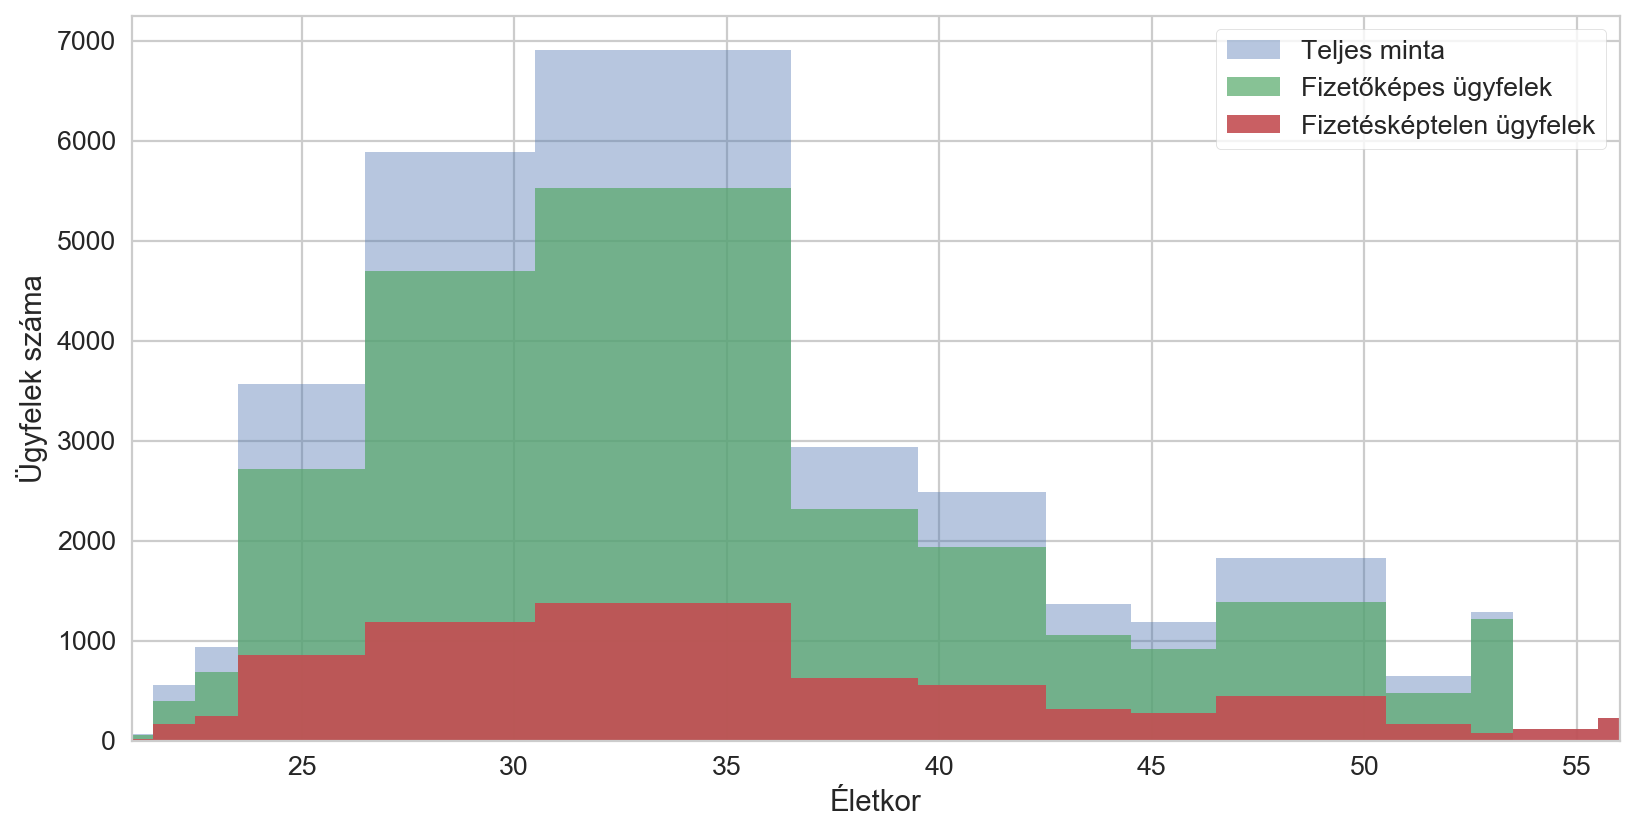

In [716]:
_,dfage_bins = astropy.stats.histogram(dfage.Életkor,bins='blocks')
plt.rcParams['figure.figsize'] = [12, 6]
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
t_clrp = sns.color_palette()
sns.set(font_scale=1.2)
sns.set_style("whitegrid",{'legend.frameon':True})
sns.distplot(dfage.Életkor,bins=dfage_bins,ax=ax2, kde=True, hist=False)
#ax2.grid(False)
sns.distplot(dfage.Életkor,bins=dfage_bins,ax=ax1, kde=False, hist=True,label='Teljes minta',color=t_clrp[0])
#sns.distplot([0],bins=dfage_bins,ax=ax1, kde=True, hist=False,label='Kernel sűrűségfüggvény becslése',color=t_clrp[0])
sns.distplot(dfage.Életkor[(dfage.FizKépt == 0)],bins=dfage_bins,ax=ax1,
             kde=False, hist=True,label='Fizetőképes ügyfelek',color=t_clrp[1],hist_kws=dict(alpha=0.7))
sns.distplot(dfage.Életkor[dfage.FizKépt == 1],bins=dfage_bins,ax=ax1, kde=False,
             hist=True,label='Fizetésképtelen ügyfelek',color=t_clrp[2],hist_kws=dict(alpha=0.9))
ax1.set(xlim=(np.min(dfage_bins),np.max(dfage_bins)))
ax1.legend(loc=0)
#ax1.set_title('Az ügyfélszám eloszlása az életkor szerint')
ax1.set(ylabel='Ügyfelek száma')
plt.show()

##### Tartozás

In [127]:
coln = df.columns[12:18][3]

In [128]:
dft = pd.DataFrame()
dft[coln] = df[coln]
dft['decile'] = pd.qcut(df[coln], 10, labels=False)
dft = dft.groupby('decile').mean()
#df_billamt[coln] = dft

In [129]:
df_billamt = pd.DataFrame()
for coln in df.columns[12:18]:
    dft = pd.DataFrame()
    dft[coln] = df[coln]
    dft['decile'] = pd.qcut(df[coln], 10, labels=False)
    dft = dft.groupby('decile').mean()
    df_billamt[coln] = dft[coln].values
df_billamt

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,-160.3,-259.3,-253.8,-262.6,-257.2,-349.0
1,897.3,644.1,551.4,501.7,404.4,304.2
2,"3,710.8","3,171.7","2,864.5","2,448.6","1,891.4","1,377.8"
3,"9,326.1","8,795.3","8,482.6","7,848.8","6,787.4","5,526.5"
4,"17,705.3","17,125.5","16,610.4","15,484.1","13,975.4","12,545.3"
5,"28,932.6","27,636.4","25,830.8","23,356.0","21,446.1","20,424.1"
6,"45,707.5","43,942.5","41,030.0","35,647.3","32,145.0","30,901.6"
7,"67,308.6","64,405.1","61,004.1","55,840.5","51,699.3","49,848.6"
8,"109,289.0","105,014.3","100,243.1","92,738.2","87,177.2","85,057.0"
9,"183,800.6","177,136.2","170,930.8","158,611.1","149,783.7","146,190.9"


In [130]:
dfbill = pd.DataFrame()
for nr in range(0,6):
    dfbill['{}'.format(var_months[nr])] = df['bill_amt{}'.format(nr+1)].copy()
dfbill['nemek'] = df.sex.copy()
dfbill['FizKépt'] = df.default.copy()

In [720]:
dstat = pd.DataFrame()
dstat_def1 = pd.DataFrame()
dstat_def0 = pd.DataFrame()
for nr in range(0,6):
    dstat.loc['{}'.format(var_months[nr]),'Átlag'] = dfbill['{}'.format(var_months[nr])].mean()
    dstat_def1.loc['{}'.format(var_months[nr]),'Átlag'] = dfbill[dfbill.FizKépt == 1]['{}'
                                                                                             .format(var_months[nr])].mean()
    dstat_def0.loc['{}'.format(var_months[nr]),'Átlag'] = dfbill[dfbill.FizKépt == 0]['{}'
                                                                                             .format(var_months[nr])].mean()

In [721]:
dstat = dstat.loc[dstat.index[::-1].tolist(),:]
dstat_def1 = dstat_def1.loc[dstat_def1.index[::-1].tolist(),:]
dstat_def0 = dstat_def0.loc[dstat_def0.index[::-1].tolist(),:]

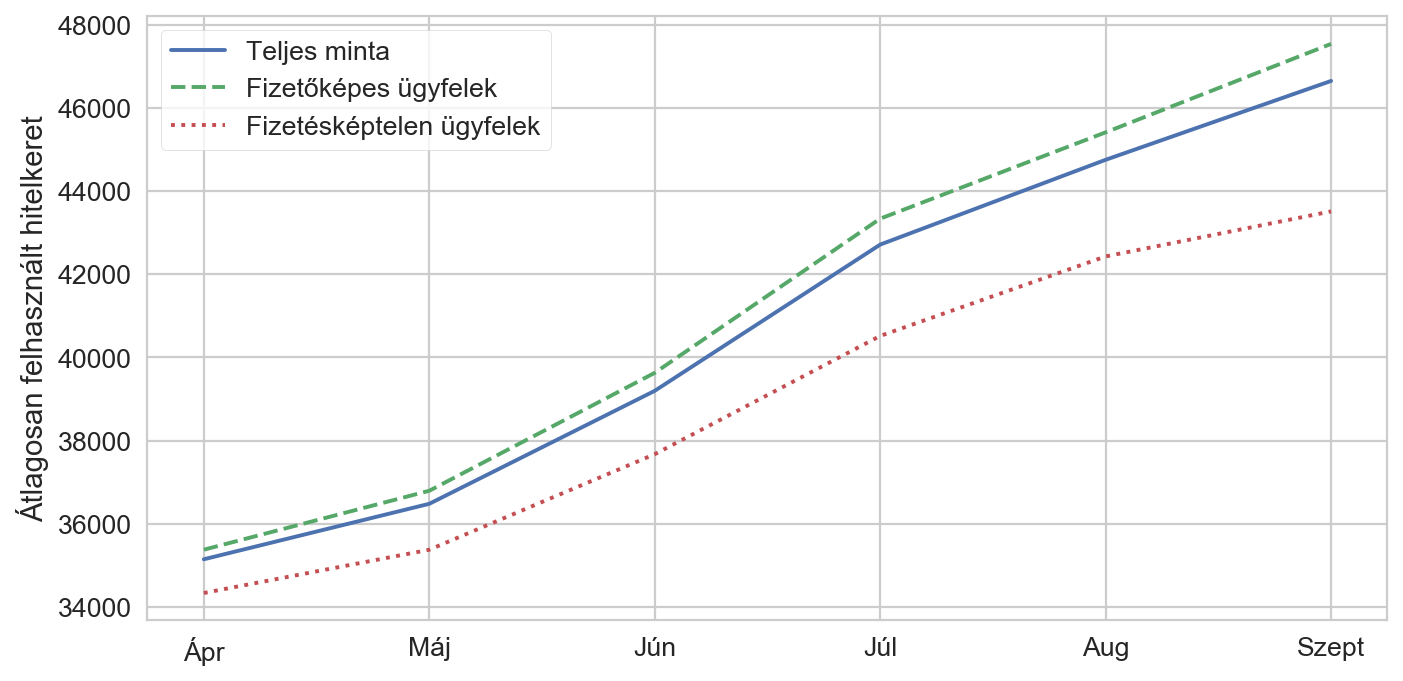

In [727]:
plt.rcParams['figure.figsize'] = [10, 5]
t_clrp = sns.color_palette()
sns.set_style("whitegrid",{'legend.frameon':True})
x = [x for x in range(len(dstat.index.values))]
yavg = dstat.Átlag
yavg1 = dstat_def1.Átlag
yavg0 = dstat_def0.Átlag
plt.plot(x,yavg,label='Teljes minta',color=t_clrp[0],linestyle='-')
plt.plot(x,yavg0,label='Fizetőképes ügyfelek',color=t_clrp[1],linestyle='--')
plt.plot(x,yavg1,label='Fizetésképtelen ügyfelek',color=t_clrp[2],linestyle=':')
locs, labels = plt.xticks() 
plt.xticks(x,dstat.index.values)
plt.legend()
plt.ylabel('Átlagosan felhasznált hitelkeret')
#plt.legend(bbox_to_anchor=(0.99, 0.25))
#plt.title('Felhasznált hitelkeret átlagának változása a fizetésképesség bontásában')
plt.show()

### Befizetett összeg

In [729]:
df_payamt = pd.DataFrame()
for coln in df.columns[18:24]:
    dft = pd.DataFrame()
    dft[coln] = df[coln]
    dft['decile'] = pd.qcut(df[coln], 11, labels=False, duplicates='drop')
    dft = dft.groupby('decile').mean()
    df_payamt[coln] = dft[coln]
df_payamt

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
decile,,,,,,
0,0.49,0.03,81.07,50.94,38.57,20.74
1,624.12,568.27,868.38,620.61,605.00,538.73
2,"1,342.80","1,250.50","1,288.16","1,010.51","1,026.67",978.94
3,"1,836.18","1,774.42","1,840.02","1,516.05","1,709.89","1,498.94"
4,"2,250.45","2,174.73","2,572.84","2,150.27","2,293.04","2,139.61"
5,"2,983.90","2,841.48","3,518.14","3,096.75","3,113.38","3,090.69"
6,"4,258.10","3,875.15","5,004.60","4,569.34","4,579.30","4,534.85"
7,"5,837.52","5,463.61","8,044.93","7,387.97","7,386.61","7,356.90"
8,"8,804.94","8,666.84","23,193.52","22,232.45","21,938.22","24,361.63"


In [730]:
dfpay = pd.DataFrame()
for nr in range(0,6):
    dfpay['{}'.format(var_months[nr])] = df['pay_amt{}'.format(nr+1)].copy()
dfpay['nemek'] = df.sex.copy()
dfpay['FizKépt'] = df.default.copy()

In [731]:
dstat = pd.DataFrame()
dstat_def0 = pd.DataFrame()
dstat_def1 = pd.DataFrame()
for nr in range(0,6):
    dstat_def0.loc['{}'.format(var_months[nr]),'Átlag'] = dfpay[dfpay.FizKépt == 0]['{}'.format(var_months[nr])].mean()
    dstat_def1.loc['{}'.format(var_months[nr]),'Átlag'] = dfpay[dfpay.FizKépt == 1]['{}'.format(var_months[nr])].mean()
    dstat.loc['{}'.format(var_months[nr]),'Átlag'] = dfpay['{}'.format(var_months[nr])].mean()

In [732]:
dstat = dstat.loc[dstat.index[::-1].tolist(),:]
dstat_def1 = dstat_def1.loc[dstat_def1.index[::-1].tolist(),:]
dstat_def0 = dstat_def0.loc[dstat_def0.index[::-1].tolist(),:]

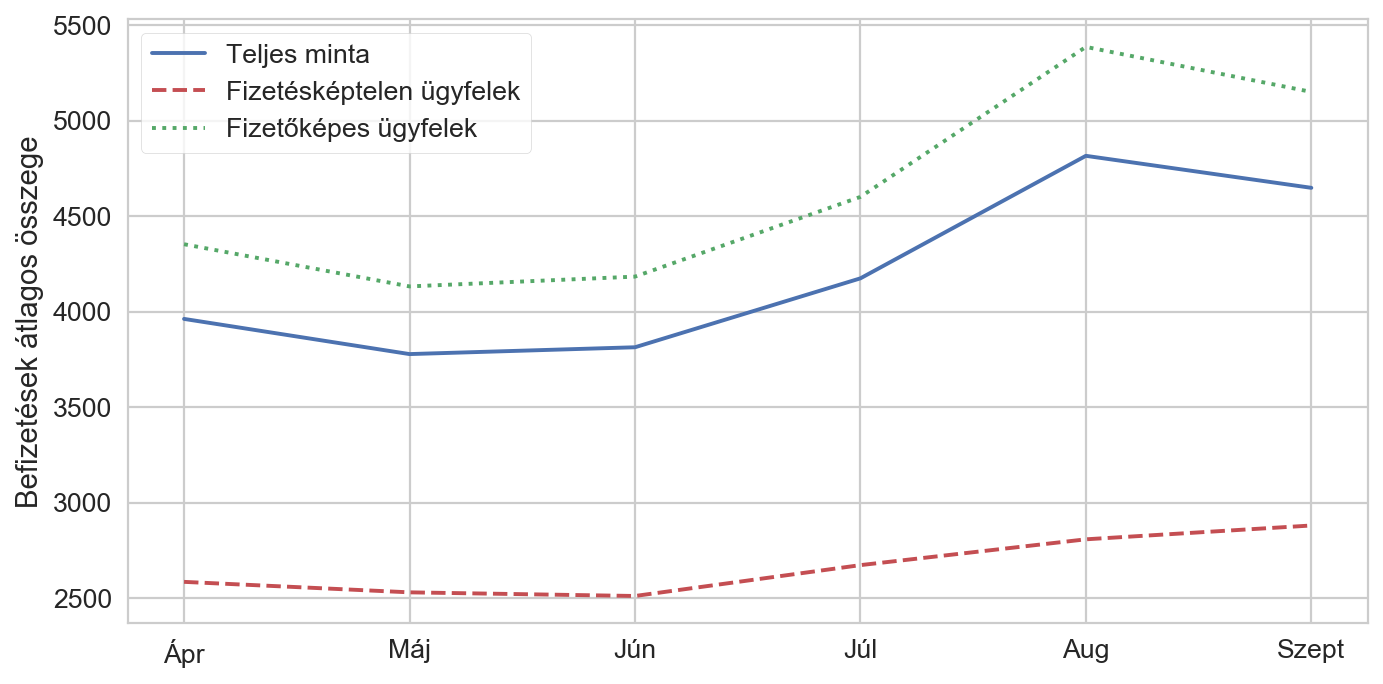

In [734]:
plt.rcParams['figure.figsize'] = [10, 5]
t_clrp = sns.color_palette()
sns.set_style("whitegrid",{'legend.frameon':True})
x = [x for x in range(len(dstat.index.values))]
yavg = dstat.Átlag
yavg1 = dstat_def1.Átlag
yavg0 = dstat_def0.Átlag
plt.plot(x,yavg,label='Teljes minta',color=t_clrp[0],linestyle='-')
plt.plot(x,yavg1,label='Fizetésképtelen ügyfelek',color=t_clrp[2],linestyle='--')
plt.plot(x,yavg0,label='Fizetőképes ügyfelek',color=t_clrp[1],linestyle=':')
locs, labels = plt.xticks() 
plt.xticks(x,dstat.index.values)
plt.legend()
plt.ylabel('Befizetések átlagos összege')
#plt.legend(bbox_to_anchor=(0.055, 0.75))
#plt.title('A befizetett összeg átlagának változása a fizetőképesség bontásában')
plt.show()

### Hibásan kódolt változó

In [139]:
cm = sns.light_palette("orange", as_cmap=True)
df_pay = pd.DataFrame()
for coln in df.columns[6:12]:
    df_pay[coln] = df.groupby(coln).size()
index = df_pay.index.values
df_pay = pd.DataFrame(df_pay.values,columns=['FizStát_{}'.format(x) for x in var_months])
df_pay.index = index
df_pay.style.background_gradient(cmap=cm).set_table_styles( [ dict(selector="th", props=[
    ('border-style','solid'),
    ('border-width', '1px'),
    ('text-align', 'center')]),
    dict(selector="td", props=[
    ('border-style','solid'),
    ('border-width', '1px'),
    ('text-align', 'center')])
    ])

,FizStát_Szept,FizStát_Aug,FizStát_Júl,FizStát_Jún,FizStát_Máj,FizStát_Ápr
-2,2759,3782,4085,4348,4546,4895
-1,5686,6050,5938,5687,5539,5740
0,14737,15730,15764,16455,16947,16286
1,3688,28,4,2,nan,nan
2,2667,3927,3819,3159,2626,2766
3,322,326,240,180,178,184
4,76,99,76,69,84,49
5,26,25,21,35,17,13
6,11,12,23,5,4,19
7,9,20,27,58,58,46


### Érettségizett és egyéb kategóriába tartozó entitások   /////////////////eltávolítása a mintából

In [140]:
dfedu = df['education'].replace({1:'Másoddiploma',2:'Egyetem',3:'Érettségi',4:'Egyéb'}).value_counts().to_frame()
dfedu['%'] = ( dfedu['education'] / dfedu['education'].sum() ) * 100
dfedu.columns = ['IskVégz','%']
dfedu

,IskVégz,%
Egyetem,14030,46.8
Másoddiploma,10585,35.3
Érettségi,4917,16.4
Egyéb,468,1.6


In [141]:
#KSH 2017 15-74 éves népesség legmagasabb isk. végz
#https://www.ksh.hu/docs/hun/xstadat/xstadat_eves/i_qlf015.html
dfksh = pd.DataFrame.from_dict({'Általános': [1540],'Szakmunkás': [1862],'Érettségi': [2531],
                                'Főiskola': [914],'Egyetem': [599]},orient='index')
dfksh.columns = ['ezer_fő']
dfksh['%'] = ( dfksh['ezer_fő'] / dfksh['ezer_fő'].sum() ) * 100
dfksh

,ezer_fő,%
Általános,1540,20.7
Szakmunkás,1862,25.0
Érettségi,2531,34.0
Főiskola,914,12.3
Egyetem,599,8.0


df = df[df['education'].isin([1,2])]

### Nemek kiegyensúlyozott aránya

In [142]:
#Nemek aránya az adatbázisban
pd.options.display.float_format = '{:.0f}'.format
df_dset_sex = pd.DataFrame()
df_dset_sex['sex'] = df['sex'].replace({1:'FF',2:'NŐ'}).value_counts()
df_dset_sex['%'] = ( df_dset_sex['sex'] / df_dset_sex['sex'].sum() ) * 100
df_dset_sex.columns = ['Nemek','%']
df_dset_sex

,Nemek,%
NŐ,18112,60
FF,11888,40


In [143]:
#Nemek aránya népességben
#https://www.ksh.hu/docs/hun/xstadat/xstadat_eves/i_qlf015.html
pd.options.display.float_format = '{:.0f}'.format
df_ksh_sex = pd.DataFrame()
df_ksh_sex.loc['Általános','NŐ'] = 880
df_ksh_sex.loc['Általános','FF'] = 660
df_ksh_sex.loc['Érettségi','NŐ'] = 621 + 750
df_ksh_sex.loc['Érettségi','FF'] = 394 + 666
df_ksh_sex.loc['Főiskola','NŐ'] = 568
df_ksh_sex.loc['Főiskola','FF'] = 346
df_ksh_sex.loc['Egyetem','NŐ'] = 288
df_ksh_sex.loc['Egyetem','FF'] = 310
df_ksh_sex[''] = ( df_ksh_sex['NŐ'] / df_ksh_sex[['NŐ','FF']].apply(lambda x: x.sum(),axis=1) ) * 100
df_ksh_sex[' '] = ( df_ksh_sex['FF'] / df_ksh_sex[['NŐ','FF']].apply(lambda x: x.sum(),axis=1) ) * 100
df_ksh_sex['NŐ'] = df_ksh_sex['NŐ'].astype('int')
df_ksh_sex['FF'] = df_ksh_sex['FF'].astype('int')
df_ksh_sex = df_ksh_sex[['NŐ','','FF',' ']]
df_ksh_sex.columns = ['NŐ','%','FF','%']

pd.options.display.float_format = '{:.0f}'.format
df_ksh_sex2 = df_ksh_sex.iloc[2:4,0:1].sum().to_frame()
df_ksh_sex2.loc['Férfi',0] = df_ksh_sex.iloc[2:4,2:3].sum().values
df_ksh_sex2.columns = ['Felsőoktatás']
df_ksh_sex2['%'] = ( df_ksh_sex2['Felsőoktatás'] / df_ksh_sex2['Felsőoktatás'].sum() ) * 100
df_ksh_sex2

,Felsőoktatás,%
NŐ,856,57
Férfi,656,43


In [144]:
## Populációban 
# sex_rat_targ = {1: 0.43,2: 0.57}
## Mintában
sex_rat_targ = {1: 0.40,2: 0.60}

### Családi állapot

In [145]:
#Dataset családi állapot aránya
pd.options.display.float_format = '{:.0f}'.format
df_dset_merr = df['marriage'].replace({1:'Házas',2:'Nőtlen/Hajadon',3:'Egyéb'}).value_counts().to_frame()
df_dset_merr['%'] = ( df_dset_merr['marriage'] / df_dset_merr['marriage'].sum() ) * 100
df_dset_merr.columns = ['CsalÁll','%']
df_dset_merr

,CsalÁll,%
Nőtlen/Hajadon,15964,53
Házas,13659,46
Egyéb,377,1


df = df[df['marriage'].isin([1,2])]
len(df)

In [146]:
pd.options.display.float_format = '{:.1f}'.format
df_dset_merr = df['marriage'].replace({1:'Házas',2:'Nőtlen/Hajadon',3:'Egyéb'}).value_counts().to_frame()
df_dset_merr['%'] = ( df_dset_merr['marriage'] / df_dset_merr['marriage'].sum() ) * 100
df_dset_merr.columns = ['CsalÁll','%']

In [147]:
#KSH 2016 A 15 éves és annál idősebb férfiak és nők megoszlása családi állapot szerint 
#https://www.ksh.hu/docs/hun/xftp/idoszaki/mikrocenzus2016/mikrocenzus_2016_2.pdf
pd.options.display.float_format = '{:.0f}%'.format
df_ksh_merr = pd.DataFrame.from_dict({'Nőtlen/Hajadon':[33.0],'Házas':[44.0],'Özvegy':[12.0],'Elvált':[11.0]},orient='index')
df_ksh_merr.columns = ['KSH']

pd.options.display.float_format = '{:.0f}%'.format
pd.DataFrame( ( df_ksh_merr.iloc[0:2,0] / df_ksh_merr.iloc[0:2,0].sum() ) * 100 )

,KSH
Nőtlen/Hajadon,43%
Házas,57%


In [148]:
##Populációban
# marr_rat_targ = {2: 0.43, 1: 0.57}
##Mintában
marr_rat_targ = {3: 0.1, 2: 0.56, 1: 0.43}

### Korcsoportok

In [149]:
df['age_decile'] = pd.qcut(df['age'], 10, labels=False)

In [150]:
pd.options.display.float_format = '{:.2f}'.format
df_age_decile = pd.DataFrame()
df_age_decile['Átlag'] = df.groupby('age_decile').mean()['age'].astype('int')
df_age_decile['Min'] = df.groupby('age_decile').min()['age'].astype('int')
df_age_decile['Max'] = df.groupby('age_decile').max()['age'].astype('int')
df_age_decile['%'] = df.groupby('age_decile')['age_decile'].count()
df_age_decile['%'] = df_age_decile['%'] / df_age_decile['%'].sum()
df_age_decile.index = df_age_decile.index.rename('Decilis')

In [151]:
#KSH Magyarország népességének száma nemek és életkor szerint, 2017 január 1.
#https://www.ksh.hu/interaktiv/korfak/orszag.html
age_dist_dict = {
(21,25) : 315.5 + 298 , (26,27) : 128.5 + 120.8 ,
(28,29) : 125.4 + 117.2 , (30,31) : 125.8 + 119.3 ,
(32,33) : 120.9 + 117.5 , (34,35) : 132.7 + 129.4 ,
(36,38) : 228.7 + 224.2 , (39,42) : 351.9 + 343.2 ,
(43,47) : 363.1 + 357.4 , (48,56) : 544.3 + 566.8 }

In [152]:
kshagedicvallist = [v for k,v in age_dist_dict.items()]
kshdictagesum = sum ( kshagedicvallist )
kshdictageratiolist = [v/kshdictagesum for v in kshagedicvallist]
ksh_age_dist_dict_v2 = dict(zip(range(len(kshdictageratiolist)),kshdictageratiolist))

In [153]:
dfs = [df_age_decile,pd.DataFrame(pd.Series(ksh_age_dist_dict_v2).rename('%'))]

df_combined = pd.concat(
    [df for df in dfs],
    keys=['Adathalmaz','KSH'],
    axis=1)
display('A fizetésképtelenség megoszlás az iskolai végzettség szerint')
df_combined

'A fizetésképtelenség megoszlás az iskolai végzettség szerint'

Adathalmaz               KSH
             Átlag Min Max    %    %
Decilis                             
0               23  21  25 0.13 0.13
1               26  26  27 0.09 0.05
2               28  28  29 0.10 0.05
3               30  30  31 0.09 0.05
4               33  32  34 0.12 0.05
5               35  35  37 0.11 0.05
6               38  38  40 0.09 0.09
7               41  41  43 0.08 0.14
8               46  44  49 0.11 0.15
9               52  50  56 0.09 0.23

In [154]:
df.decilis.unique()

array([0, 1, 4, 5, 9, 2, 7, 3, 8, 6], dtype=int64)

In [155]:
decilis_rat_targ = {0:0.1,1:0.1,2:0.1,3:0.1,4:0.1,5:0.1,6:0.1,7:0.1,8:0.1,9:0.1}

# Adatelőkészítés

In [156]:
#Nemek
df.sex = df.sex.replace({1:0,2:1})
sex_vname_code = {0:'FF',1:'NŐ'}

## Populációban 
# sex_rat_targ = {0: 0.43,1: 0.57}
## Mintában
sex_rat_targ = {0: 0.40,1: 0.60}

In [157]:
#Iskolázottság
df.education = df.education.replace({1:0,2:1,3:2,4:3})
edu_vname_code = {0:'Másoddiploma',1:'Egyetem',2:'Érettségi',3:'Egyéb'}
##Mintában
education_rat_targ = {0:0.35, 1: 0.47, 2: 0.16, 3:0.02}

In [158]:
#Családi állapot
df.marriage = df.marriage.replace({1:0,2:1,3:1})
marr_vname_code ={0:'Házas',1:'Nőtlen/Hajadon',1:'Egyéb'}

##Populációban
# marr_rat_targ = {2: 0.43, 1: 0.57}
##Mintában
marr_rat_targ = {1: 0.47, 0: 0.53}

In [736]:
#Fizetési hátralék
df_months_lst = [1,2,3,4,5,6]
for mn in df_months_lst:
    newvar = 'paid_full{}'.format(mn)
    oldvar = 'pay_{}'.format(mn)
    df.loc[:,newvar] = 0
    df.loc[df.loc[:,oldvar] == -1,newvar] = 1
for mn in df_months_lst:
    newvar = 'paid_no_trans{}'.format(mn)
    oldvar = 'pay_{}'.format(mn)
    df.loc[:,newvar] = 0
    df.loc[df.loc[:,oldvar] == -2,newvar] = 1
for mn in df_months_lst:
    oldvar = 'pay_{}'.format(mn)
    df.loc[:,oldvar] = df.loc[:,oldvar].replace({-2:0,-1:0})

In [160]:
# A felhasznált hitelkeret és Büntetés nélkül felhasználható hitelkeret aránya
for nr in range(1,7):
    df['BLrat_{}'.format(nr)] = df['bill_amt{}'.format(nr)] / df['limit_bal']

In [161]:
#A befizetés és a mérleg aránya
for nr in range(1,6):
    df['BParat_{}'.format(nr)] =  df['pay_amt{}'.format(nr)] / df['bill_amt{}'.format(nr+1)]

In [162]:
df[['BParat_{}'.format(nr) for nr in range(1,6)]].isnull().sum()

BParat_1    2468
BParat_2    2814
BParat_3    3150
BParat_4    3449
BParat_5    3959
dtype: int64

In [163]:
for col in ['BParat_{}'.format(nr) for nr in range(1,6)]:
    df.loc[df[col].isin([np.inf, -np.inf, np.nan]),col] = 1

In [164]:
for col in ['BParat_{}'.format(nr) for nr in range(1,6)]:
     df.loc[df[col] < 0,col] = 1

In [165]:
df[['BParat_{}'.format(nr) for nr in range(1,6)]].isin([np.inf, -np.inf, np.nan]).sum()

BParat_1    0
BParat_2    0
BParat_3    0
BParat_4    0
BParat_5    0
dtype: int64

## Új változók vizsgálata

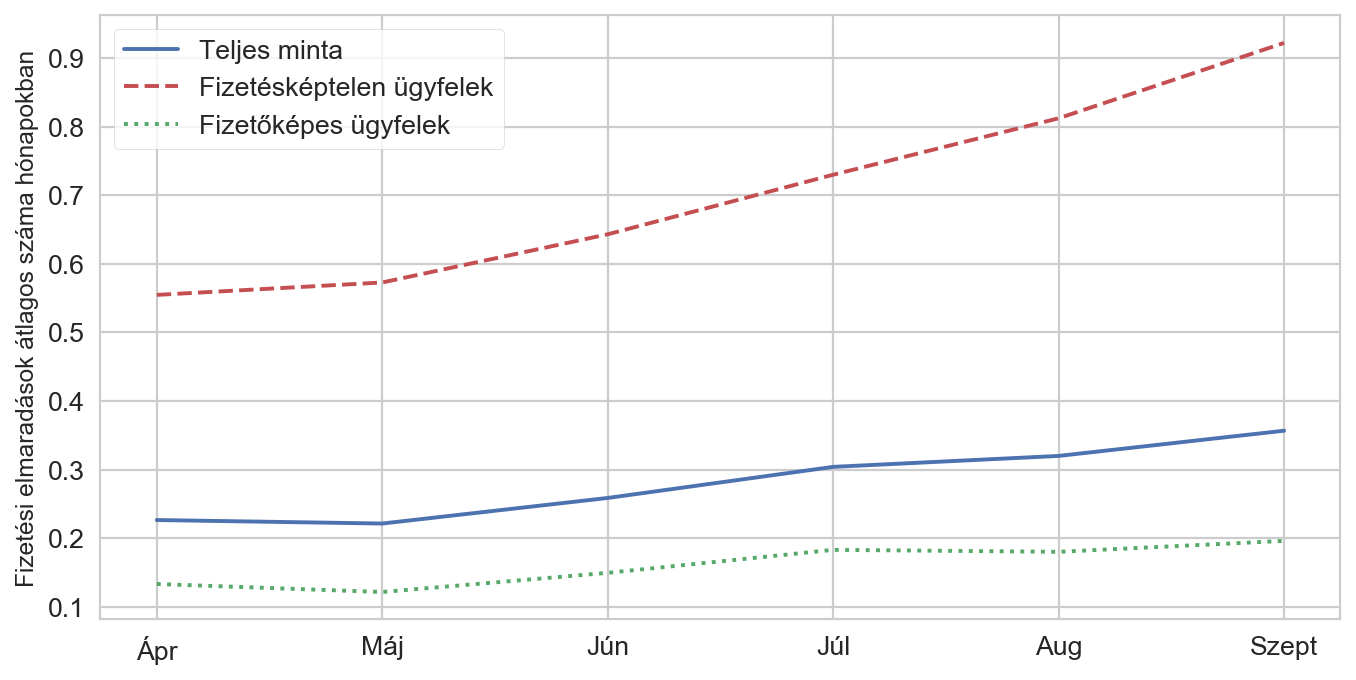

In [743]:
#Minimális fizetési kötelezettség elmaradása hónapokban
dfpaydel = pd.DataFrame()
dfpaydel_def0 = pd.DataFrame()
dfpaydel_def1 = pd.DataFrame()
for cnum in range(len(df.columns[6:12])):
    cn =  df.columns[6:12][cnum]
    dfpaydel.loc['FizElm_{}'.format(var_months[cnum]),'Átlag'] = df[cn].mean()
    dfpaydel_def0.loc['FizElm_{}'.format(var_months[cnum]),'Átlag'] = df.loc[df.default == 0,cn].mean()
    dfpaydel_def1.loc['FizElm_{}'.format(var_months[cnum]),'Átlag'] = df.loc[df.default == 1,cn].mean()

dfpaydel = dfpaydel.loc[dfpaydel.index[::-1].tolist(),:]
dfpaydel_def1 = dfpaydel_def1.loc[dfpaydel_def1.index[::-1].tolist(),:]
dfpaydel_def0 = dfpaydel_def0.loc[dfpaydel_def0.index[::-1].tolist(),:]
    
plt.rcParams['figure.figsize'] = [10, 5]
t_clrp = sns.color_palette()
sns.set_style("whitegrid",{'legend.frameon':True})
x = [x for x in range(len(dfpaydel.index.values))]
yavg = dfpaydel.Átlag
yavg1 = dfpaydel_def1.Átlag
yavg0 = dfpaydel_def0.Átlag
plt.plot(x,yavg,label='Teljes minta',color=t_clrp[0],linestyle='-')
plt.plot(x,yavg1,label='Fizetésképtelen ügyfelek',color=t_clrp[2],linestyle='--')
plt.plot(x,yavg0,label='Fizetőképes ügyfelek',color=t_clrp[1],linestyle=':')
locs, labels = plt.xticks() 
plt.xticks(x,var_months[::-1])
plt.legend()
plt.ylabel('Fizetési elmaradások átlagos száma hónapokban', fontsize=11)
plt.show()

In [167]:
#A számla mérleg átlagának alakulása a hitelkeret arányában
dflimitbill_rat_def1 = pd.DataFrame()
for nr in range(1,7):
    dflimitbill_rat_def1.loc['{}'.format(var_months[nr-1]),'Átlag'] = df[df.default == 1]['BLrat_{}'.format(nr)].mean()
dflimitbill_rat_def0 = pd.DataFrame()
for nr in range(1,7):
    dflimitbill_rat_def0.loc['{}'.format(var_months[nr-1]),'Átlag'] = df[df.default == 0]['BLrat_{}'.format(nr)].mean()
dflimitbill_rat = pd.DataFrame()
for nr in range(1,7):
    dflimitbill_rat.loc['{}'.format(var_months[nr-1]),'Átlag'] = df['BLrat_{}'.format(nr)].mean()

In [168]:
dflimitbill_rat = dflimitbill_rat.loc[dflimitbill_rat.index[::-1].tolist(),:]
dflimitbill_rat_def1 = dflimitbill_rat_def1.loc[dflimitbill_rat_def1.index[::-1].tolist(),:]
dflimitbill_rat_def0 = dflimitbill_rat_def0.loc[dflimitbill_rat_def0.index[::-1].tolist(),:]

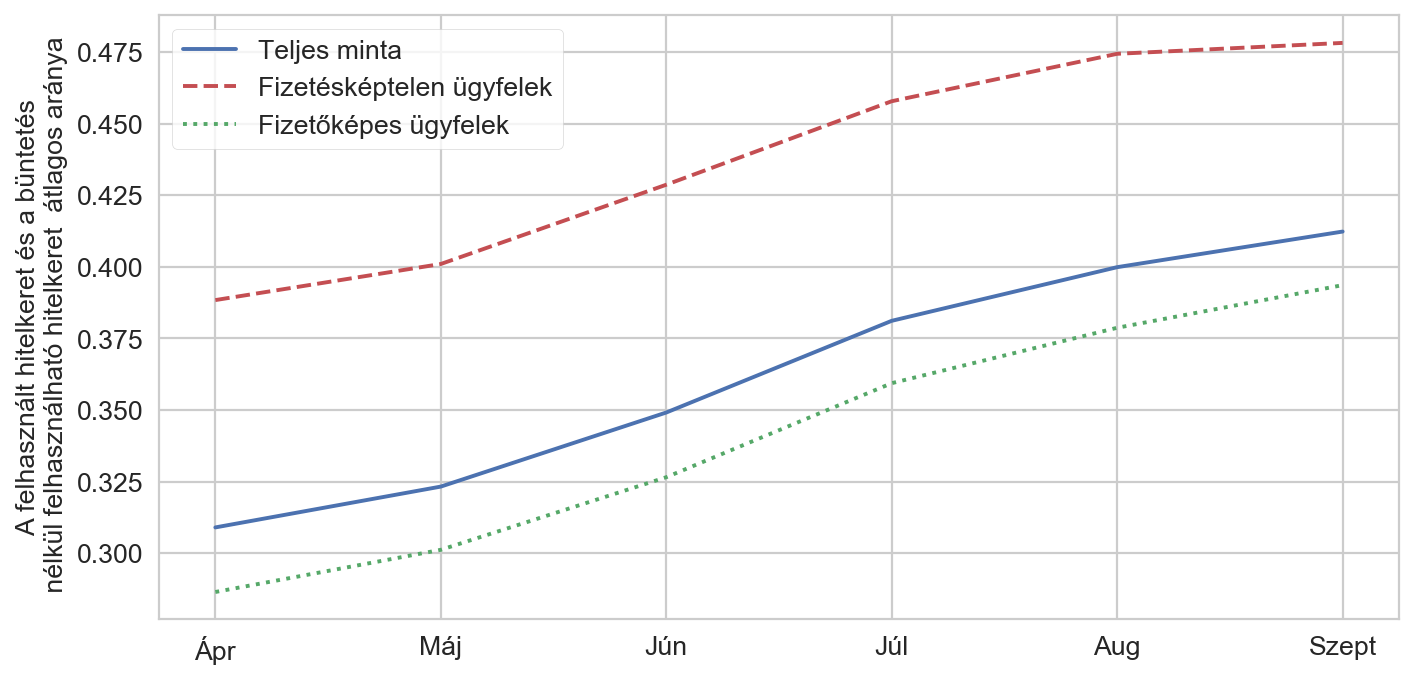

In [752]:
plt.rcParams['figure.figsize'] = [10, 5]
t_clrp = sns.color_palette()
sns.set_style("whitegrid",{'legend.frameon':True})
x = [x for x in range(len(dflimitbill_rat.index.values))]
yavg = dflimitbill_rat.Átlag
yavg1 = dflimitbill_rat_def1.Átlag
yavg0 = dflimitbill_rat_def0.Átlag
plt.plot(x,yavg,label='Teljes minta',color=t_clrp[0],linestyle='-')
plt.plot(x,yavg1,label='Fizetésképtelen ügyfelek',color=t_clrp[2],linestyle='--')
plt.plot(x,yavg0,label='Fizetőképes ügyfelek',color=t_clrp[1],linestyle=':')
locs, labels = plt.xticks() 
plt.xticks(x,var_months[::-1])
plt.legend()
plt.ylabel('A felhasznált hitelkeret és a büntetés\n nélkül felhasználható hitelkeret  átlagos aránya', fontsize=12)
plt.show()

In [170]:
#Befizetések átlagának alakulása a felhasznált hitelkeret arányában
dflimitpaya_rat_def1 = pd.DataFrame()
for nr in range(1,6):
    dflimitpaya_rat_def1.loc['{}'.format(var_months[nr-1]),'Átlag'] = df[df.default == 1]['BParat_{}'
    .format(nr)].mean(skipna=True)
dflimitpaya_rat_def0 = pd.DataFrame()
for nr in range(1,6):
    dflimitpaya_rat_def0.loc['{}'.format(var_months[nr-1]),'Átlag'] = df[df.default == 0]['BParat_{}'
    .format(nr)].mean(skipna=True)
dflimitpaya_rat = pd.DataFrame()
for nr in range(1,6):
    dflimitpaya_rat.loc['{}'.format(var_months[nr-1]),'Átlag'] = df['BParat_{}'.format(nr)].mean(skipna=True)

In [171]:
dflimitpaya_rat = dflimitpaya_rat.loc[dflimitpaya_rat.index[::-1].tolist(),:]
dflimitpaya_rat_def1 = dflimitpaya_rat_def1.loc[dflimitpaya_rat_def1.index[::-1].tolist(),:]
dflimitpaya_rat_def0 = dflimitpaya_rat_def0.loc[dflimitpaya_rat_def0.index[::-1].tolist(),:]

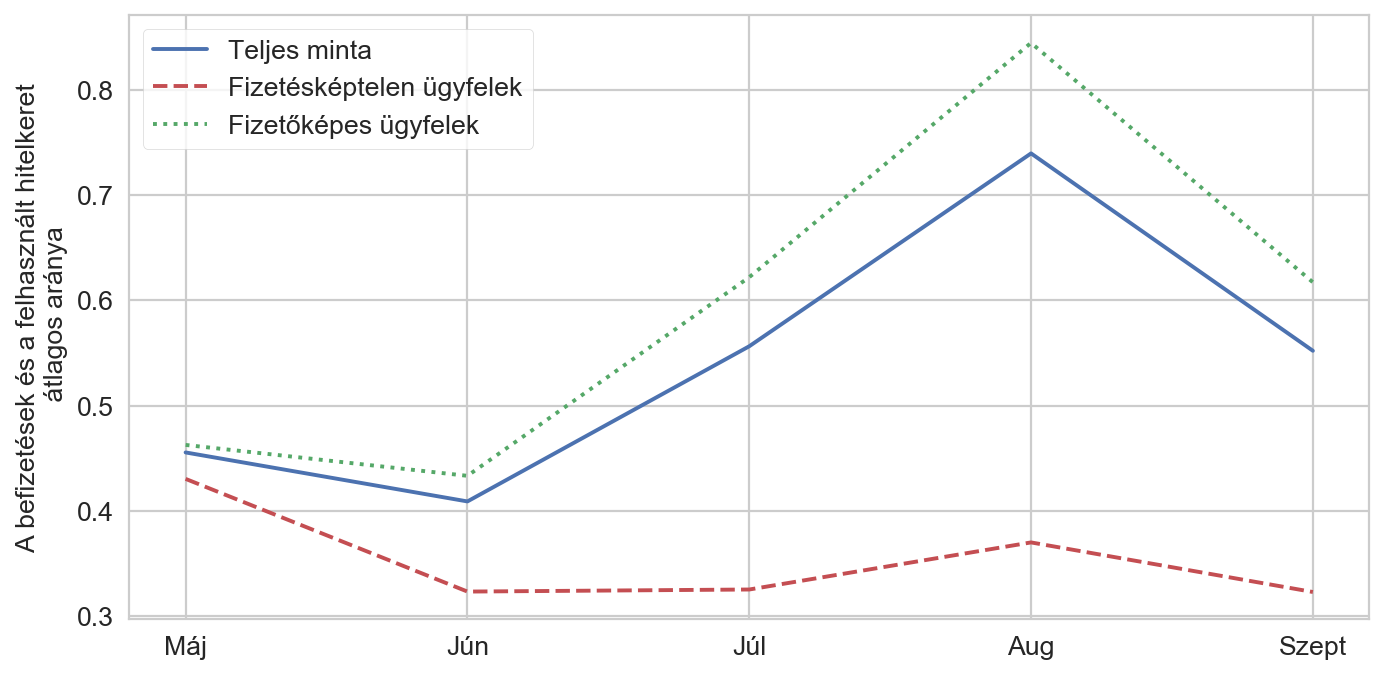

In [751]:
plt.rcParams['figure.figsize'] = [10, 5]
t_clrp = sns.color_palette()
sns.set_style("whitegrid",{'legend.frameon':True})
x = [x for x in range(len(dflimitpaya_rat.index.values))]
yavg = dflimitpaya_rat.Átlag
yavg1 = dflimitpaya_rat_def1.Átlag
yavg0 = dflimitpaya_rat_def0.Átlag
plt.plot(x,yavg,label='Teljes minta',color=t_clrp[0],linestyle='-')
plt.plot(x,yavg1,label='Fizetésképtelen ügyfelek',color=t_clrp[2],linestyle='--')
plt.plot(x,yavg0,label='Fizetőképes ügyfelek',color=t_clrp[1],linestyle=':')
locs, labels = plt.xticks() 
plt.xticks(x,dflimitpaya_rat.index.values)
plt.legend(loc=2)
plt.ylabel('A befizetések és a felhasznált hitelkeret\n átlagos aránya', fontsize=12)
plt.show()

## Kiegyensúlyozott adathalmaz létrehozása

In [173]:
def calcwght(iratvar,dictinp,df_baled):
    idf = df_baled[[iratvar,'wght']].copy()
    for nk in range(len(dictinp.keys())):
        ratval = list(dictinp.keys())[nk]
        dfvarsum = idf.loc[:,'wght'].sum()
        dfvalsum = idf.loc[df_baled[iratvar] == ratval,'wght'].sum()
        dfrat = dfvalsum / dfvarsum
        poprat = dictinp[ratval]
        finvalwght = poprat / dfrat
        idf.loc[idf[iratvar] == ratval,'wght_temp'] = finvalwght
    del idf[iratvar]
    del idf['wght']
    return idf

In [174]:
marr_rat_targ

{1: 0.47, 0: 0.53}

In [175]:
def crt_new_weight(input_df,silent=True):
    input_df['sex_wght1'] = calcwght('sex',sex_rat_targ,input_df)
    new_wght = input_df['wght'] * input_df['sex_wght1']
    if silent == False:
        print('MSE:','{:.10f}'.format(np.around ( mean_squared_error(input_df['wght'], new_wght) , decimals = 10 )))
    input_df['wght'] = new_wght

    input_df['age_wght1'] = calcwght('age_decile',decilis_rat_targ,input_df)
    new_wght = input_df['wght'] * input_df['age_wght1'] 
    if silent == False:
        print('MSE:','{:.10f}'.format(np.around ( mean_squared_error(input_df['wght'], new_wght) , decimals = 10 )))
    input_df['wght'] = new_wght
    
    input_df['marr_wght1'] = calcwght('marriage',marr_rat_targ,input_df)
    new_wght = input_df['wght'] * input_df['marr_wght1'] 
    if silent == False:
        print('MSE:','{:.10f}'.format(np.around ( mean_squared_error(input_df['wght'], new_wght) , decimals = 10 )))
    input_df['wght'] = new_wght
    
    input_df['default_wght1'] = calcwght('default',default_rat_targ,input_df)
    new_wght = input_df['wght'] * input_df['default_wght1'] 
    if silent == False:
        print('MSE:','{:.10f}'.format(np.around ( mean_squared_error(input_df['wght'], new_wght) , decimals = 10 )))
    input_df['wght'] = new_wght
    
    input_df['education_wght1'] = calcwght('education',education_rat_targ,input_df)
    new_wght = input_df['wght'] * input_df['education_wght1']
    if silent == False:
        print('MSE:','{:.10f}'.format(np.around ( mean_squared_error(input_df['wght'], new_wght) , decimals = 10 )))
    input_df['wght'] = new_wght
    
    input_df['decilis_wght1'] = calcwght('decilis',decilis_rat_targ,input_df)
    new_wght = input_df['wght'] * input_df['decilis_wght1']
    if silent == False:
        print('MSE:','{:.10f}'.format(np.around ( mean_squared_error(input_df['wght'], new_wght) , decimals = 10 )))
    input_df['wght'] = new_wght
    return input_df['wght']

In [176]:
df_baled = df.copy()
del df_baled['id']
df_baled['wght'] = 1

In [177]:
df_baled.shape

(30000, 50)

In [178]:
for n in range(10):
    clear_output()
    df_baled['wght'] = crt_new_weight(df_baled,silent=False)

MSE: 0.0000000000
MSE: 0.0000000000
MSE: 0.0000000000
MSE: 0.0000000000
MSE: 0.0000000000
MSE: 0.0000000000


In [179]:
df_baled['wght'].apply( lambda x: round(x,2) ).min()

0.39

In [180]:
df_baled['wght'].apply( lambda x: round(x,2) ).max()

5.58

In [181]:
wghtmin = round( 1 / 
                df_baled['wght']
                .apply( lambda x: round(x,2) )
                .min(),0 )
wghtmin

3.0

In [182]:
def crt_bal_data(input_df,silent=True):
    input_df['wght'] = 1
    for n in range(5):
        if silent == False:
            clear_output()
        input_df['wght'] = crt_new_weight(input_df,silent=True)
    input_df['wght'] = input_df['wght'].apply(lambda x: round(x,2) )
    wghtmin = round( 1 / 
                df_baled['wght']
                .apply( lambda x: round(x,2) )
                .min(),0 )
    input_df['wght'] = input_df['wght']*wghtmin
    input_df['wght'] = input_df['wght'].apply(lambda x: int(x) )
    wght_dict = dict(zip( 
        input_df['wght'].value_counts().index,
        input_df['wght'].value_counts().index * input_df['wght'].value_counts().values 
                            ))   
    ros = RandomOverSampler(random_state=42, ratio=wght_dict)
    x_train_ros, _ = ros.fit_sample(
        input_df.loc[:,input_df.columns[0:49]].copy(),
        input_df['wght'])
    return pd.DataFrame(x_train_ros,columns=input_df.columns[0:49])

In [183]:
warnings.filterwarnings('ignore')
df_baled_teszt = crt_bal_data(df.drop('id',axis=1),silent=False)

In [184]:
### Kiegyensúlyozott adathalmaz visszemérése 

In [185]:
defedu = df_baled_teszt['default'].value_counts().to_frame()
defedu['%'] = ( defedu['default'] / defedu['default'].sum() ) * 100
defedu

,default,%
1.00,41699,56.14
0.00,32579,43.86


In [186]:
pd.options.display.float_format = '{:.2f}'.format
df_age_decile = pd.DataFrame()
df_age_decile['%'] = df_baled_teszt.groupby('age_decile')['age_decile'].count()
df_age_decile['%'] = df_age_decile['%'] / df_age_decile['%'].sum()
df_age_decile

,%
age_decile,
0.00,0.10
1.00,0.10
2.00,0.09
3.00,0.10
4.00,0.09
5.00,0.10
6.00,0.10
7.00,0.10
8.00,0.09


In [187]:
df_dset_sex = pd.DataFrame()
df_dset_sex['sex'] = df_baled_teszt['sex'].replace({0:'FF',1:'NŐ'}).value_counts()
df_dset_sex['%'] = ( df_dset_sex['sex'] / df_dset_sex['sex'].sum() ) * 100
df_dset_sex

,sex,%
NŐ,44389,59.76
FF,29889,40.24


In [188]:
pd.options.display.float_format = '{:.1f}'.format
df_dset_merr = df_baled_teszt['marriage'].replace({0:'Házas',1:'Nőtlen/Hajadon',2:'Egyéb'}).value_counts().to_frame()
df_dset_merr['%'] = ( df_dset_merr['marriage'] / df_dset_merr['marriage'].sum() ) * 100
df_dset_merr

,marriage,%
Házas,40286,54.2
Nőtlen/Hajadon,33992,45.8


In [189]:
del df_baled_teszt

# Modellezés

In [190]:
def imb_x_train(df):
    idf = df.copy()
    del idf['id']
    del idf['decilis']
    del idf['age_decile']
    del idf['default']
    del idf['sex']
    idf['education'] = idf['education'].astype(int)
    idf = pd.get_dummies(idf,columns=['education'])
    return idf
    
def imb_y_train(df):
    return df['default'].values

def bal_x_train(df):
    idf = df.copy()
    del idf['id']
    warnings.filterwarnings('ignore')
    idf = crt_bal_data(idf)
    idf['education'] = idf['education'].astype(int)
    idf = pd.get_dummies(idf,columns=['education'])
    del idf['decilis']
    del idf['age_decile']
    del idf['default']
    del idf['sex']
    return idf
 
def bal_y_train(df):
    idf = df.copy()
    del idf['id']
    warnings.filterwarnings('ignore')
    idf = crt_bal_data(idf)
    return idf['default'].values

def imb_x_test(df):
    idf = df.copy()
    del idf['id']
    del idf['decilis'] 
    del idf['age_decile']
    del idf['default']
    del idf['sex']
    idf['education'] = idf['education'].astype(int)
    idf = pd.get_dummies(idf,columns=['education'])
    return idf

def imb_y_test(df):
    return df['default'].values

In [191]:
def logreg_imb_x_train(df):
    idf = df.copy()
    del idf['id']
    del idf['decilis']
    del idf['age_decile']
    del idf['default']
    del idf['sex']
    idf['education'] = idf['education'].astype(int)
    idf = pd.get_dummies(idf,columns=['education'])
    idf = idf.drop(['pay_2','pay_3','pay_5','pay_6'],axis=1)
    idf = idf.drop(['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6'],axis=1)
    idf = idf.drop(['paid_full2','paid_full3','paid_full4','paid_full5'],axis=1)
    idf = idf.drop(['paid_no_trans2','paid_no_trans3','paid_no_trans4','paid_no_trans5','paid_no_trans6'],axis=1)
    idf = idf.drop(['BLrat_1','BLrat_2','BLrat_3','BLrat_4','BLrat_5','BLrat_6'],axis=1)
    idf = idf.drop(['BParat_2','BParat_3'],axis=1)
    return idf
    
def logreg_imb_y_train(df):
    return df['default'].values


def logreg_bal_x_train(df):
    idf = df.copy()
    del idf['id']
    warnings.filterwarnings('ignore')
    idf = crt_bal_data(idf)
    idf['education'] = idf['education'].astype(int)
    idf = pd.get_dummies(idf,columns=['education'])
    del idf['decilis']
    del idf['age_decile']
    del idf['default']
    del idf['sex']
    idf = idf.drop(['pay_2','pay_3','pay_5','pay_6'],axis=1)
    idf = idf.drop(['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6'],axis=1)
    idf = idf.drop(['paid_full2','paid_full3','paid_full4','paid_full5'],axis=1)
    idf = idf.drop(['paid_no_trans2','paid_no_trans3','paid_no_trans4','paid_no_trans5','paid_no_trans6'],axis=1)
    idf = idf.drop(['BLrat_1','BLrat_2','BLrat_3','BLrat_4','BLrat_5','BLrat_6'],axis=1)
    idf = idf.drop(['BParat_2','BParat_3'],axis=1)
    return idf
 
def logreg_bal_y_train(df):
    idf = df.copy()
    del idf['id']
    warnings.filterwarnings('ignore')
    idf = crt_bal_data(idf)
    return idf['default'].values

def logreg_imb_x_test(df):
    idf = df.copy()
    del idf['id']
    del idf['decilis'] 
    del idf['age_decile']
    del idf['default']
    del idf['sex']
    idf['education'] = idf['education'].astype(int)
    idf = pd.get_dummies(idf,columns=['education'])
    idf = idf.drop(['pay_2','pay_3','pay_5','pay_6'],axis=1)
    idf = idf.drop(['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6'],axis=1)
    idf = idf.drop(['paid_full2','paid_full3','paid_full4','paid_full5'],axis=1)
    idf = idf.drop(['paid_no_trans2','paid_no_trans3','paid_no_trans4','paid_no_trans5','paid_no_trans6'],axis=1)
    idf = idf.drop(['BLrat_1','BLrat_2','BLrat_3','BLrat_4','BLrat_5','BLrat_6'],axis=1)
    idf = idf.drop(['BParat_2','BParat_3'],axis=1)
    return idf

def logreg_imb_y_test(df):
    return df['default'].values

## LogisticRegression

In [192]:
baled_df = df.copy()
del baled_df['id']
baled_df = crt_bal_data(baled_df)
del baled_df['decilis'] 
del baled_df['age_decile']
del baled_df['sex']

In [193]:
def _color_red_or_green(val):
    color = 'red' if val > 0.5 else 'green'
    return 'color: %s' % color

In [194]:
baled_df = baled_df.drop(['pay_2','pay_3','pay_5','pay_6'],axis=1)
baled_df = baled_df.drop(['bill_amt2','bill_amt3','bill_amt4','bill_amt5','bill_amt6'],axis=1)
baled_df = baled_df.drop(['paid_full2','paid_full3','paid_full4','paid_full5'],axis=1)
baled_df = baled_df.drop(['paid_no_trans2','paid_no_trans3','paid_no_trans4','paid_no_trans5','paid_no_trans6'],axis=1)
baled_df = baled_df.drop(['BLrat_1','BLrat_2','BLrat_3','BLrat_4','BLrat_5','BLrat_6'],axis=1)
baled_df = baled_df.drop(['BParat_2','BParat_3'],axis=1)

In [195]:
baled_df = pd.get_dummies(baled_df,columns=['education'])

In [196]:
baled_df.corr().style.applymap(_color_red_or_green)

,limit_bal,marriage,age,pay_1,pay_4,bill_amt1,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,paid_full1,paid_full6,paid_no_trans1,BParat_1,BParat_4,BParat_5,education_0.0,education_1.0,education_2.0,education_3.0
limit_bal,1,-0.0922787,0.130208,-0.200507,-0.215253,0.235801,0.29769,0.293712,0.297137,0.294076,0.295838,0.298315,-0.215606,0.159899,0.161334,0.239213,0.00838369,0.129509,0.00903774,0.279098,-0.160715,-0.156645,0.0311059
marriage,-0.0922787,1,-0.463339,-0.0182305,-0.0107671,-0.0223146,-0.00520183,-0.0117322,-0.00640286,-0.00848318,-0.00399789,-0.00642976,-0.0339167,-0.0173844,-0.0248499,-0.0232247,0.00293384,-0.0211875,-0.0156376,0.159863,-0.0622011,-0.11967,-0.00873044
age,0.130208,-0.463339,1,0.00507372,0.0038211,0.025622,0.0214644,0.0271979,0.0220947,0.0252339,0.0175423,0.0199771,0.0237951,0.0304825,0.0343257,0.0467311,0.00763996,0.0351946,-0.00947502,-0.0988717,-0.0703362,0.21894,0.0105689
pay_1,-0.200507,-0.0182305,0.00507372,1,0.485498,0.0574803,-0.155608,-0.134817,-0.121017,-0.107113,-0.0955609,-0.0956068,0.378791,-0.289031,-0.166564,-0.187018,-0.00954243,-0.126697,-0.0266237,-0.0834885,0.063948,0.0450522,-0.0595423
pay_4,-0.215253,-0.0107671,0.0038211,0.485498,1,-0.0150833,-0.0948223,-0.0749347,-0.147475,-0.103447,-0.0940519,-0.0974335,0.259892,-0.146115,-0.161514,-0.123602,-0.00834397,-0.134428,-0.027376,-0.0704371,0.0483726,0.0483292,-0.0573633
bill_amt1,0.235801,-0.0223146,0.025622,0.0574803,-0.0150833,1,0.309657,0.249238,0.262371,0.269358,0.272091,0.260517,-0.0298999,-0.297671,-0.255183,-0.202311,-0.0165871,-0.212134,-0.0353168,-0.0343153,0.0352271,-0.0279331,0.0634937
pay_amt1,0.29769,-0.00520183,0.0214644,-0.155608,-0.0948223,0.309657,1,0.399526,0.365763,0.346227,0.338227,0.336979,-0.183967,0.0486976,0.0121687,0.00308797,0.00723048,-0.0328916,-0.00875203,0.0822926,-0.0561841,-0.0445206,0.0353116
pay_amt2,0.293712,-0.0117322,0.0271979,-0.134817,-0.0749347,0.249238,0.399526,1,0.359179,0.332908,0.327695,0.321641,-0.177892,0.0694097,0.0260547,0.0180154,0.00532564,-0.017931,-0.00400744,0.0726712,-0.0540867,-0.0443243,0.0594574
pay_amt3,0.297137,-0.00640286,0.0220947,-0.121017,-0.147475,0.262371,0.365763,0.359179,1,0.351886,0.337556,0.334072,-0.155752,0.0594997,0.021983,0.0139108,0.00579572,-0.0279738,-0.010434,0.0751724,-0.0455817,-0.0546017,0.0480712
pay_amt4,0.294076,-0.00848318,0.0252339,-0.107113,-0.103447,0.269358,0.346227,0.332908,0.351886,1,0.344534,0.334412,-0.141218,0.0306688,0.040341,0.0193357,0.013978,0.0801504,-0.012156,0.0766695,-0.0432161,-0.0479652,0.0179473


In [ ]:
#%matplotlib inline
for coln in baled_df.drop(['default'],axis=1).columns:
    plt.figure()
    sns.regplot(x= coln, y= 'default', data= baled_df, logistic= True).set_title(f"{coln} Log Odds Linear Plot")
    plt.show()

## Xgboost

In [197]:
sk_kf = KFold(n_splits=3, random_state=42,shuffle=False)

In [198]:
# Imbalanced 

In [199]:
def XgbRandomParamSearchCV_Imb(df, param_grid, n_iter=5, nsplit=2):
    search_time_start = time.time()
    best_score = 0
    best_params = 0
    best_fit_num = 0
    fit_counter = 0
    for rn in range(n_iter):
        fit_counter = rn+1
        lparams = {}
        for dk in param_grid.keys():
            lparams[dk] = param_grid[dk][np.random.randint(0,len(param_grid[dk]))]
        auc_int = []
        sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
        for train_index, test_index in sk_kf.split(df):
            x_train = imb_x_train(df.iloc[train_index,:])
            y_train = imb_y_train(df.iloc[train_index,:])
            x_test = imb_x_test(df.iloc[test_index,:])
            y_test = imb_y_test(df.iloc[test_index,:])
            xgb_model = XGBClassifier(n_estimators=1500, n_jobs=8, silent=True,  eval_metric='auc', **lparams)
            eval_set  = [(x_train,y_train), (x_test,y_test)]
            xgb_model.fit(x_train, y_train, eval_set=eval_set,eval_metric="auc",early_stopping_rounds=25, verbose=0)
            pred_prob = xgb_model.predict_proba(x_test)
            result_prob = pd.DataFrame(pred_prob,columns=["Prob_0","Prob_1"])
            auc = auc_score(y_test, result_prob["Prob_1"])
            auc_int.append(auc)                                                    
        if np.mean(auc_int) > best_score:
            best_score = np.mean(auc_int)
            best_params = lparams 
            best_fit_num = rn+1
        print('Fit:{}'.format(rn+1),'/ Elpased:{:.2f}min'.format((time.time() - search_time_start)/60),'/ AUC:{:.3f}'
              .format(np.mean(auc_int)),'/ {}'.format(lparams))
        if (time.time() - search_time_start)/60 > 30:
            break
    runtime = time.time() - search_time_start
    clear_output(wait=True)
    print('Best-','AUC:{:.3f}'.format(best_score),'RunTime:{:.2f}min'.format(runtime/60),'sumfit:{}'.format(fit_counter), 'nth_fit:{}'.format(best_fit_num),'{}'.format(best_params))
    return best_score, best_params

In [200]:
param_grid = { 
    'max_depth': np.arange(1,15,1),
    'learning_rate':  np.around(np.arange(0.05,0.45,0.05),decimals=2),
    'subsample': np.around(np.arange(0.3,1.1,0.1),decimals=2),
    'colsample_bytree': np.around(np.arange(0+1/imb_x_train(df).shape[1],1+1/imb_x_train(df).shape[1],
                                            1/imb_x_train(df).shape[1]),decimals=2),
    'colsample_bylevel': np.around(np.arange(0+1/imb_x_train(df).shape[1],1+1/imb_x_train(df).shape[1],
                                             1/imb_x_train(df).shape[1]),decimals=2),
    'min_child_weight': np.arange(5,100,5),
    'gamma': np.arange(0,16,2),
    #'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    }

In [201]:
XgbBestParams_imb =  {'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.27, 'colsample_bylevel': 0.83, 'min_child_weight': 5, 'gamma': 10}

In [202]:
# Balanced

In [203]:
def XgbRandomParamSearchCV_bal(df, param_grid, n_iter=5, nsplit=2):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    search_time_start = time.time()
    best_score = 0
    best_params = 0
    best_fit_num = 0
    fit_counter = 0
    for rn in range(n_iter):
        fit_counter = rn+1
        lparams = {}
        for dk in param_grid.keys():
            lparams[dk] = param_grid[dk][np.random.randint(0,len(param_grid[dk]))]
        auc_int = []
        sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
        for train_index, test_index in sk_kf.split(df):
            x_train = bal_x_train(df.iloc[train_index,:])
            y_train = bal_y_train(df.iloc[train_index,:])
            x_test = imb_x_test(df.iloc[test_index,:])
            y_test = imb_y_test(df.iloc[test_index,:])
            xgb_model = XGBClassifier(n_estimators=1500, n_jobs=8, silent=True,  eval_metric='auc', **lparams)
            eval_set  = [(x_train,y_train), (x_test,y_test)]
            xgb_model.fit(x_train, y_train, eval_set=eval_set,eval_metric="auc",early_stopping_rounds=25, verbose=0)
            pred_prob = xgb_model.predict_proba(x_test)
            result_prob = pd.DataFrame(pred_prob,columns=["Prob_0","Prob_1"])
            auc = auc_score(y_test, result_prob["Prob_1"])
            auc_int.append(auc)                                                    
        if np.mean(auc_int) > best_score:
            best_score = np.mean(auc_int)
            best_params = lparams 
            best_fit_num = rn+1
        print('Fit:{}'.format(rn+1),'/ Elpased:{:.2f}min'.format((time.time() - search_time_start)/60),
              '/ AUC:{:.3f}'.format(np.mean(auc_int)),'/ {}'.format(lparams))
        if (time.time() - search_time_start)/60 > 30:
            break
    runtime = time.time() - search_time_start
    clear_output(wait=True)
    print('Best-','AUC:{:.3f}'.format(best_score),'RunTime:{:.2f}min'.format(runtime/60),'sumfit:{}'.format(fit_counter), 'nth_fit:{}'.format(best_fit_num),'{}'.format(best_params))
    return best_score, best_params

In [204]:
param_grid = { 
    'max_depth': np.arange(1,15,1),
    'learning_rate':  np.around(np.arange(0.05,0.45,0.05),decimals=2),
    'subsample': np.around(np.arange(0.3,1.1,0.1),decimals=2),
    'colsample_bytree': np.around(np.arange(0+1/imb_x_train(df)
                                            .shape[1],1+1/imb_x_train(df).shape[1],1/imb_x_train(df).shape[1]),decimals=2),
    'colsample_bylevel': np.around(np.arange(0+1/imb_x_train(df)
                                             .shape[1],1+1/imb_x_train(df).shape[1],1/imb_x_train(df).shape[1]),decimals=2),
    'min_child_weight': np.arange(5,100,5),
    'gamma': np.arange(0,16,2),
    #'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    }

In [205]:
XgbBestParams_bal = {'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.5, 'colsample_bytree': 0.62, 'colsample_bylevel': 0.54, 'min_child_weight': 5, 'gamma': 10}

## Sklearn DecisionTree

In [206]:
# Imbalanced 

In [207]:
def DTreeRandomParamSearchCV_Imb(df, param_grid, n_iter=5, nsplit=2):
    search_time_start = time.time()
    best_score = 0
    best_params = 0
    best_fit_num = 0
    fit_counter = 0
    for rn in range(n_iter):
        fit_counter = rn+1
        lparams = {}
        for dk in param_grid.keys():
            lparams[dk] = param_grid[dk][np.random.randint(0,len(param_grid[dk]))]
        param_grid['min_samples_leaf'] = np.arange(1, lparams['min_samples_split'], int(np.ceil(lparams['min_samples_split']/20)))
        lparams['min_samples_leaf'] = param_grid['min_samples_leaf'][np.random.randint(0,len(param_grid['min_samples_leaf']))]
        auc_int = []
        sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
        for train_index, test_index in sk_kf.split(df):
            x_train = imb_x_train(df.iloc[train_index,:])
            y_train = imb_y_train(df.iloc[train_index,:])
            x_test = imb_x_test(df.iloc[test_index,:])
            y_test = imb_y_test(df.iloc[test_index,:])
            DTree = tree.DecisionTreeClassifier(splitter="best", random_state=42,criterion="gini", **lparams)
            DTree.fit(x_train, y_train)
            pred_prob = DTree.predict_proba(x_test)
            result_prob = pd.DataFrame(pred_prob,columns=["Prob_0","Prob_1"])
            auc = auc_score(y_test, result_prob["Prob_1"])
            auc_int.append(auc)                                                    
        if np.mean(auc_int) > best_score:
            best_score = np.mean(auc_int)
            best_params = lparams 
            best_fit_num = rn+1
        print('Fit:{}'.format(rn+1),'/ Elpased:{:.2f}min'
              .format((time.time() - search_time_start)/60),'/ AUC:{:.3f}'.format(np.mean(auc_int)),'/ {}'.format(lparams))
        if (time.time() - search_time_start)/60 > 30:
            break
    runtime = time.time() - search_time_start
    clear_output(wait=True)
    print('Best-','AUC:{:.3f}'.format(best_score),'RunTime:{:.2f}min'
          .format(runtime/60),'sumfit:{}'.format(fit_counter), 'nth_fit:{}'.format(best_fit_num),'{}'.format(best_params))
    return best_score, best_params

In [208]:
param_grid = {
    'max_depth': np.arange(1,15,1),
    'max_features': np.arange(1,( imb_x_train(df).shape[1] ),1),
    'min_samples_split': np.arange(2,30,2),
    'min_samples_leaf': np.arange(1,15,2),
    }

In [209]:
DTreeBestParams_imb = {'max_depth': 9, 'max_features': 27, 'min_samples_split': 26, 'min_samples_leaf': 23}

In [210]:
# Balanced

In [211]:
def DTreeRandomParamSearchCV_bal(df, param_grid, n_iter=5, nsplit=2):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    search_time_start = time.time()
    best_score = 0
    best_params = 0 
    best_fit_num = 0
    fit_counter = 0
    for rn in range(n_iter):
        fit_counter = rn+1
        lparams = {}
        for dk in param_grid.keys():
            lparams[dk] = param_grid[dk][np.random.randint(0,len(param_grid[dk]))]
        param_grid['min_samples_leaf'] = np.arange(1, lparams['min_samples_split'], int(np.ceil(lparams['min_samples_split']/20)))
        lparams['min_samples_leaf'] = param_grid['min_samples_leaf'][np.random.randint(0,len(param_grid['min_samples_leaf']))]
        auc_int = []
        sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
        for train_index, test_index in sk_kf.split(df):
            x_train = bal_x_train(df.iloc[train_index,:])
            y_train = bal_y_train(df.iloc[train_index,:])
            x_test = imb_x_test(df.iloc[test_index,:])
            y_test = imb_y_test(df.iloc[test_index,:])
            DTree = tree.DecisionTreeClassifier(splitter="best", random_state=42,criterion="gini", **lparams)
            DTree.fit(x_train, y_train)
            pred_prob = DTree.predict_proba(x_test)
            result_prob = pd.DataFrame(pred_prob,columns=["Prob_0","Prob_1"])
            auc = auc_score(y_test, result_prob["Prob_1"])
            auc_int.append(auc)                                                    
        if np.mean(auc_int) > best_score:
            best_score = np.mean(auc_int)
            best_params = lparams 
            best_fit_num = rn+1
        print('Fit:{}'.format(rn+1),'/ Elpased:{:.2f}min'
              .format((time.time() - search_time_start)/60),'/ AUC:{:.3f}'.format(np.mean(auc_int)),'/ {}'.format(lparams))
        if (time.time() - search_time_start)/60 > 30:
            break
    runtime = time.time() - search_time_start
    clear_output(wait=True)
    print('Best-','AUC:{:.3f}'.format(best_score),'RunTime:{:.2f}min'
          .format(runtime/60),'sumfit:{}'.format(fit_counter), 'nth_fit:{}'.format(best_fit_num),'{}'.format(best_params))
    return best_score, best_params

In [212]:
param_grid = {
    'max_depth': np.arange(1,15,1),
    'max_features': np.arange(1,( imb_x_train(df).shape[1] ),1),
    'min_samples_split': np.arange(2,30,2),
    'min_samples_leaf': np.arange(1,15,2),
    }

In [213]:
DTreeBestParams_bal = {'max_depth': 9, 'max_features': 46, 'min_samples_split': 4, 'min_samples_leaf': 2}

## Sklearn RandomForest

In [214]:
#Imbalanced

In [215]:
def RandomForestRandomParamSearchCV_Imb(df, param_grid, n_iter=5, nsplit=2):
    search_time_start = time.time()
    best_score = 0
    best_params = 0 
    best_fit_num = 0
    fit_counter = 0
    for rn in range(n_iter):
        fit_counter = rn+1
        lparams = {}
        for dk in param_grid.keys():
            lparams[dk] = param_grid[dk][np.random.randint(0,len(param_grid[dk]))]
        param_grid['min_samples_leaf'] = np.arange(1, lparams['min_samples_split'], int(np.ceil(lparams['min_samples_split']/20)))
        lparams['min_samples_leaf'] = param_grid['min_samples_leaf'][np.random.randint(0,len(param_grid['min_samples_leaf']))]
        auc_int = []
        sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
        for train_index, test_index in sk_kf.split(df):
            x_train = imb_x_train(df.iloc[train_index,:])
            y_train = imb_y_train(df.iloc[train_index,:])
            x_test = imb_x_test(df.iloc[test_index,:])
            y_test = imb_y_test(df.iloc[test_index,:])
            RForest = RandomForestClassifier(random_state=42, **lparams)
            RForest.fit(x_train, y_train)
            pred_prob = RForest.predict_proba(x_test)
            result_prob = pd.DataFrame(pred_prob,columns=["Prob_0","Prob_1"])
            auc = auc_score(y_test, result_prob["Prob_1"])
            auc_int.append(auc)                                                    
        if np.mean(auc_int) > best_score:
            best_score = np.mean(auc_int)
            best_params = lparams 
            best_fit_num = rn+1
        print('Fit:{}'.format(rn+1),'/ Elpased:{:.2f}min'
              .format((time.time() - search_time_start)/60),'/ AUC:{:.3f}'.format(np.mean(auc_int)),'/ {}'.format(lparams))
        if (time.time() - search_time_start)/60 > 30:
            break
    runtime = time.time() - search_time_start
    clear_output(wait=True)
    print('Best-','AUC:{:.3f}'.format(best_score),'RunTime:{:.2f}min'
          .format(runtime/60),'sumfit:{}'.format(fit_counter), 'nth_fit:{}'.format(best_fit_num),'{}'.format(best_params))
    return best_score, best_params

In [216]:
param_grid = {
    'bootstrap': [True],
    'n_jobs': [8],
    'n_estimators' : np.arange(100,1600,100),
    'max_depth': np.arange(1,15,1),
    'max_features': np.arange(1,(imb_x_test(df).shape[1] ),1),
    'min_samples_split':  np.arange(5,100,5)
    }


In [217]:
RForestBestParams_imb = {'bootstrap': True, 'n_jobs': 8, 'n_estimators': 1400, 'max_depth': 14, 'max_features': 20, 'min_samples_split': 30, 'min_samples_leaf': 11}

In [218]:
#Balanced
def RandomForestRandomParamSearchCV_bal(df, param_grid, n_iter=5, nsplit=2):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    search_time_start = time.time()
    best_score = 0
    best_params = 0 
    best_fit_num = 0
    fit_counter = 0
    for rn in range(n_iter):
        fit_counter = rn+1
        lparams = {}
        for dk in param_grid.keys():
            lparams[dk] = param_grid[dk][np.random.randint(0,len(param_grid[dk]))]
        param_grid['min_samples_leaf'] = np.arange(1, lparams['min_samples_split'],
                                                   int(np.ceil(lparams['min_samples_split']/20)))
        lparams['min_samples_leaf'] = param_grid['min_samples_leaf'][np.random.randint(0,len(param_grid['min_samples_leaf']))]
        auc_int = []
        sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
        for train_index, test_index in sk_kf.split(df):
            x_train = bal_x_train(df.iloc[train_index,:])
            y_train = bal_y_train(df.iloc[train_index,:])
            x_test = imb_x_test(df.iloc[test_index,:])
            y_test = imb_y_test(df.iloc[test_index,:])
            RForest = RandomForestClassifier(random_state=42, **lparams)
            RForest.fit(x_train, y_train)
            pred_prob = RForest.predict_proba(x_test)
            result_prob = pd.DataFrame(pred_prob,columns=["Prob_0","Prob_1"])
            auc = auc_score(y_test, result_prob["Prob_1"])
            auc_int.append(auc)                                                    
        if np.mean(auc_int) > best_score:
            best_score = np.mean(auc_int)
            best_params = lparams 
            best_fit_num = rn+1
        print('Fit:{}'.format(rn+1),'/ Elpased:{:.2f}min'
              .format((time.time() - search_time_start)/60),'/ AUC:{:.3f}'.format(np.mean(auc_int)),'/ {}'.format(lparams))
        if (time.time() - search_time_start)/60 > 30:
            break
    runtime = time.time() - search_time_start
    clear_output(wait=True)
    print('Best-','AUC:{:.3f}'.format(best_score),'RunTime:{:.2f}min'
          .format(runtime/60),'sumfit:{}'.format(fit_counter), 'nth_fit:{}'.format(best_fit_num),'{}'.format(best_params))
    return best_score, best_params

In [219]:
param_grid = {
    'bootstrap': [True],
    'n_jobs': [8],
    'n_estimators' : np.arange(100,1600,100),
    'max_depth': np.arange(1,15,1),
    'max_features': np.arange(1,(imb_x_test(df).shape[1] ),1),
    'min_samples_split':  np.arange(5,100,5)
    }


In [220]:
RForestBestParams_bal = {'bootstrap': True, 'n_jobs': 8, 'n_estimators': 1100, 'max_depth': 14, 'max_features': 10, 'min_samples_split': 40, 'min_samples_leaf': 11}

# Visszamérés

### Sklearn LogisticRegression

In [221]:
def kfold_valid_logreg(df,nsplit=3):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    #Imbalanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = logreg_imb_x_train(df.iloc[train_index,:])
        y_train = logreg_imb_y_train(df.iloc[train_index,:])
        x_test = logreg_imb_x_test(df.iloc[test_index,:])
        y_test = logreg_imb_y_test(df.iloc[test_index,:])
        sklin = linear_model.LogisticRegression()
        sklin.fit(x_train, y_train)
        pred = sklin.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = sklin.predict_proba(x_test)
        df_result_prob_imb = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_imb["Prob_1"] ) )
    kvalid = pd.DataFrame()
    kvalid.loc['AUC', 'Imblanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Imblanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Imblanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Imblanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Imblanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Imblanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Imblanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Imblanced'] = np.mean(matt)
    #Balanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = logreg_bal_x_train(df.iloc[train_index,:])
        y_train = logreg_bal_y_train(df.iloc[train_index,:])
        x_test = logreg_imb_x_test(df.iloc[test_index,:])
        y_test = logreg_imb_y_test(df.iloc[test_index,:])
        sklin = linear_model.LogisticRegression()
        sklin.fit(x_train, y_train)
        pred = sklin.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = sklin.predict_proba(x_test)
        df_result_prob_imb = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_imb["Prob_1"] ) )
    kvalid.loc['AUC', 'Balanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Balanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Balanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Balanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Balanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Balanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Balanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Balanced'] = np.mean(matt) 
    return kvalid

In [222]:
pd.options.display.float_format = '{:.3f}'.format
df_logreg_valid = kfold_valid_logreg(df,nsplit=3)
df_logreg_valid

,Imblanced,Balanced
AUC,0.644,0.756
Accuracy,0.779,0.635
Precision,0.000,0.354
Recall,0.000,0.745
F1_score,0.000,0.477
Jaccard_sim,0.779,0.635
Log_loss,7.640,12.623
Matthews_CC,0.000,0.293


### Xgboost

In [223]:
def kfold_valid_xgb(df,XgbBestParams_Imb,XgbBestParams_bal,nsplit=3):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    #Imbalanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = imb_x_train(df.iloc[train_index,:])
        y_train = imb_y_train(df.iloc[train_index,:])
        x_test = imb_x_test(df.iloc[test_index,:])
        y_test = imb_y_test(df.iloc[test_index,:])
        xgb_model = XGBClassifier(n_estimators=1500, n_jobs=-1, silent=True,  eval_metric='auc', **XgbBestParams_imb)
        eval_set  = [(x_train,y_train), (x_test,y_test)]
        xgb_model.fit(x_train, y_train, eval_set=eval_set,eval_metric="auc",early_stopping_rounds=100, verbose=0)
        pred = xgb_model.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = xgb_model.predict_proba(x_test)
        df_result_prob_imb = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_imb["Prob_1"] ) )
    kvalid = pd.DataFrame()
    kvalid.loc['AUC', 'Imblanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Imblanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Imblanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Imblanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Imblanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Imblanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Imblanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Imblanced'] = np.mean(matt)
    #Balanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = bal_x_train(df.iloc[train_index,:])
        y_train = bal_y_train(df.iloc[train_index,:])
        x_test = imb_x_test(df.iloc[test_index,:])
        y_test = imb_y_test(df.iloc[test_index,:])
        xgb_model = XGBClassifier(n_estimators=1500, n_jobs=-1, silent=True,  eval_metric='auc', **XgbBestParams_bal)
        eval_set  = [(x_train,y_train), (x_test,y_test)]
        xgb_model.fit(x_train, y_train, eval_set=eval_set,eval_metric="auc",early_stopping_rounds=100, verbose=0)
        pred = xgb_model.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = xgb_model.predict_proba(x_test)
        df_result_prob_imb = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_imb["Prob_1"] ) )
    kvalid.loc['AUC', 'Balanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Balanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Balanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Balanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Balanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Balanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Balanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Balanced'] = np.mean(matt) 
    return kvalid

In [224]:
pd.options.display.float_format = '{:.3f}'.format
df_xgb_valid = kfold_valid_xgb(df,XgbBestParams_imb,XgbBestParams_bal,nsplit=3)
df_xgb_valid

,Imblanced,Balanced
AUC,0.867,0.864
Accuracy,0.855,0.775
Precision,0.775,0.495
Recall,0.486,0.759
F1_score,0.598,0.599
Jaccard_sim,0.855,0.775
Log_loss,5.012,7.784
Matthews_CC,0.535,0.472


### Sklearn DecisionTree

In [225]:
def kfold_valid_dtree(df,DTreeBestParams_Imb,DTreeBestParams_bal,nsplit=3):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    #Imbalanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = imb_x_train(df.iloc[train_index,:])
        y_train = imb_y_train(df.iloc[train_index,:])
        x_test = imb_x_test(df.iloc[test_index,:])
        y_test = imb_y_test(df.iloc[test_index,:])
        DTree = tree.DecisionTreeClassifier(splitter="best", random_state=42,criterion="gini", **DTreeBestParams_imb)
        DTree.fit(x_train, y_train)
        pred = DTree.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = DTree.predict_proba(x_test)
        df_result_prob_imb = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_imb["Prob_1"] ) )
    kvalid = pd.DataFrame()
    kvalid.loc['AUC', 'Imblanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Imblanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Imblanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Imblanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Imblanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Imblanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Imblanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Imblanced'] = np.mean(matt)
    #Balanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = bal_x_train(df.iloc[train_index,:])
        y_train = bal_y_train(df.iloc[train_index,:])
        x_test = imb_x_test(df.iloc[test_index,:])
        y_test = imb_y_test(df.iloc[test_index,:])
        DTree = tree.DecisionTreeClassifier(splitter="best", random_state=42,criterion="gini", **DTreeBestParams_bal)
        DTree.fit(x_train, y_train)
        pred = DTree.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = DTree.predict_proba(x_test)
        df_result_prob_bal = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_bal["Prob_1"] ) )
    kvalid.loc['AUC', 'Balanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Balanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Balanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Balanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Balanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Balanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Balanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Balanced'] = np.mean(matt) 
    return kvalid

In [226]:
pd.options.display.float_format = '{:.3f}'.format
df_dtree_valid = kfold_valid_dtree(df,DTreeBestParams_imb,DTreeBestParams_bal,nsplit=3)
df_dtree_valid

,Imblanced,Balanced
AUC,0.802,0.799
Accuracy,0.835,0.689
Precision,0.729,0.394
Recall,0.404,0.756
F1_score,0.520,0.518
Jaccard_sim,0.835,0.689
Log_loss,5.706,10.753
Matthews_CC,0.457,0.358


### Sklearn RandomForest

In [227]:
def kfold_valid_rforest(df,RForestBestParams_Imb,RForestBestParams_bal,nsplit=3):
    sk_kf = KFold(n_splits=nsplit, random_state=42,shuffle=False)
    #Imbalanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = imb_x_train(df.iloc[train_index,:])
        y_train = imb_y_train(df.iloc[train_index,:])
        x_test = imb_x_test(df.iloc[test_index,:])
        y_test = imb_y_test(df.iloc[test_index,:])
        rforest = RandomForestClassifier(random_state=42, **RForestBestParams_Imb)
        rforest.fit(x_train, y_train)
        pred = rforest.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = rforest.predict_proba(x_test)
        df_result_prob_imb = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_imb["Prob_1"] ) )
    kvalid = pd.DataFrame()
    kvalid.loc['AUC', 'Imblanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Imblanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Imblanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Imblanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Imblanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Imblanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Imblanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Imblanced'] = np.mean(matt)
    #Balanced
    acc = []
    prec = []
    rec = []
    f1 = []
    jacc = []
    log = []
    matt = []
    auc = []
    for train_index, test_index in sk_kf.split(df):
        x_train = bal_x_train(df.iloc[train_index,:])
        y_train = bal_y_train(df.iloc[train_index,:])
        x_test = imb_x_test(df.iloc[test_index,:])
        y_test = imb_y_test(df.iloc[test_index,:])
        rforest = RandomForestClassifier(random_state=42, **RForestBestParams_bal)
        rforest.fit(x_train, y_train)
        pred = rforest.predict(x_test)
        acc.append( accuracy_score( y_test, pred ) )
        prec.append( precision_score( y_test, pred ) )
        rec.append( recall_score( y_test, pred ) )
        f1.append( f1_score( y_test, pred ) )
        jacc.append( jaccard_similarity_score( y_test, pred ) )
        log.append(  log_loss( y_test, pred ) )
        matt.append( matthews_corrcoef(y_test, pred) )
        prob = rforest.predict_proba(x_test)
        df_result_prob_bal = pd.DataFrame( prob,columns=["Prob_0","Prob_1"] )
        auc.append( auc_score(y_test, df_result_prob_bal["Prob_1"] ) )
    kvalid.loc['AUC', 'Balanced'] = np.mean(auc)             
    kvalid.loc['Accuracy', 'Balanced'] = np.mean(acc)
    kvalid.loc['Precision', 'Balanced'] = np.mean(prec)
    kvalid.loc['Recall', 'Balanced'] = np.mean(rec)
    kvalid.loc['F1_score', 'Balanced'] = np.mean(f1)
    kvalid.loc['Jaccard_sim', 'Balanced'] = np.mean(jacc)
    kvalid.loc['Log_loss', 'Balanced'] = np.mean(log)
    kvalid.loc['Matthews_CC', 'Balanced'] = np.mean(matt) 
    return kvalid

In [228]:
pd.options.display.float_format = '{:.3f}'.format
df_rforest_valid = kfold_valid_rforest(df,RForestBestParams_imb,RForestBestParams_bal,nsplit=3)
df_rforest_valid

,Imblanced,Balanced
AUC,0.832,0.840
Accuracy,0.840,0.775
Precision,0.738,0.495
Recall,0.432,0.698
F1_score,0.545,0.579
Jaccard_sim,0.840,0.775
Log_loss,5.518,7.781
Matthews_CC,0.480,0.443


## Összegzés

In [230]:
dfs = [df_logreg_valid,df_dtree_valid,df_rforest_valid,df_xgb_valid]
df_combined = pd.concat(
    [df for df in dfs],
    keys=['LogisticRegression','DecisionTree','XGBoost'],
    axis=1)
dfout = df_combined.iloc[0:5]
dfout

LogisticRegression          DecisionTree            XGBoost         
                   Imblanced Balanced    Imblanced Balanced Imblanced Balanced
AUC                    0.644    0.756        0.802    0.799     0.832    0.840
Accuracy               0.779    0.635        0.835    0.689     0.840    0.775
Precision              0.000    0.354        0.729    0.394     0.738    0.495
Recall                 0.000    0.745        0.404    0.756     0.432    0.698
F1_score               0.000    0.477        0.520    0.518     0.545    0.579

# A döntéshez vezető logika magyarázata - interpretálás

In [231]:
writer = pd.ExcelWriter('df_combined.xlsx')
dfout.to_excel(writer,'Sheet1')
writer.save()

In [262]:
# 200 véletlenszerú elem az adathalmazból
random.seed(42)
tst_pool_interp = [df.index.tolist()[random.randint(0, len(df.index))] for n in range(0,5000)]
trn_pool_interp = [x for x in df.index.tolist() if x not in tst_pool_interp]

In [263]:
len(df.index.tolist()),len(tst_pool_interp),len(trn_pool_interp)

(30000, 5000, 25375)

## Xgboost model betanítása

In [264]:
x_train = bal_x_train(df.loc[trn_pool_interp,:])
y_train = bal_y_train(df.loc[trn_pool_interp,:])
x_test = imb_x_test(df.loc[tst_pool_interp,:])
y_test = imb_y_test(df.loc[tst_pool_interp,:])

In [265]:
fparams = XgbBestParams_bal.copy()
fparams['eval_metric'] = 'auc'

In [266]:
train_dmatr = xgb.DMatrix(x_train.values, label=y_train, feature_names = x_train.columns.values.tolist())
test_dmatr = xgb.DMatrix(x_test.values, label=y_test, feature_names = x_test.columns.values.tolist())

In [267]:
watchlist  = [ (train_dmatr,'train'),(test_dmatr,'test')]

In [268]:
fin_xgbm = xgb.train(fparams, train_dmatr, 1500, watchlist,early_stopping_rounds=100)

[0]	train-auc:0.757199	test-auc:0.762848
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[1]	train-auc:0.788472	test-auc:0.793497
[2]	train-auc:0.822361	test-auc:0.829663
[3]	train-auc:0.825116	test-auc:0.834534
[4]	train-auc:0.831448	test-auc:0.839392
[5]	train-auc:0.831443	test-auc:0.839631
[6]	train-auc:0.833717	test-auc:0.840603
[7]	train-auc:0.834751	test-auc:0.840228
[8]	train-auc:0.83752	test-auc:0.843378
[9]	train-auc:0.83884	test-auc:0.844128
[10]	train-auc:0.838959	test-auc:0.844203
[11]	train-auc:0.840117	test-auc:0.845491
[12]	train-auc:0.840111	test-auc:0.84643
[13]	train-auc:0.841149	test-auc:0.846605
[14]	train-auc:0.842856	test-auc:0.848249
[15]	train-auc:0.843879	test-auc:0.849706
[16]	train-auc:0.845068	test-auc:0.850592
[17]	train-auc:0.84667	test-auc:0.851396
[18]	train-auc:0.84758	test-auc:0.851516
[19]	train-auc:0.847542	test-auc:0.851298
[20]	train-auc:0.847776	test-auc:

[191]	train-auc:0.866979	test-auc:0.866829
[192]	train-auc:0.866979	test-auc:0.866829
[193]	train-auc:0.866979	test-auc:0.866829
[194]	train-auc:0.866979	test-auc:0.866829
[195]	train-auc:0.866979	test-auc:0.866829
[196]	train-auc:0.866979	test-auc:0.866829
[197]	train-auc:0.866979	test-auc:0.866829
[198]	train-auc:0.866979	test-auc:0.866829
[199]	train-auc:0.866979	test-auc:0.866829
[200]	train-auc:0.866979	test-auc:0.866829
[201]	train-auc:0.866979	test-auc:0.866829
[202]	train-auc:0.867228	test-auc:0.867038
[203]	train-auc:0.867228	test-auc:0.867038
[204]	train-auc:0.867228	test-auc:0.867038
[205]	train-auc:0.867228	test-auc:0.867038
[206]	train-auc:0.867228	test-auc:0.867038
[207]	train-auc:0.867228	test-auc:0.867038
[208]	train-auc:0.867228	test-auc:0.867038
[209]	train-auc:0.867228	test-auc:0.867038
[210]	train-auc:0.867228	test-auc:0.867038
[211]	train-auc:0.867228	test-auc:0.867038
[212]	train-auc:0.867228	test-auc:0.867038
[213]	train-auc:0.867228	test-auc:0.867038
[214]	train

[383]	train-auc:0.868821	test-auc:0.867666
[384]	train-auc:0.868821	test-auc:0.867666
[385]	train-auc:0.868821	test-auc:0.867666
[386]	train-auc:0.868821	test-auc:0.867666
[387]	train-auc:0.868821	test-auc:0.867666
[388]	train-auc:0.868821	test-auc:0.867666
[389]	train-auc:0.868821	test-auc:0.867666
[390]	train-auc:0.868821	test-auc:0.867666
[391]	train-auc:0.868821	test-auc:0.867666
[392]	train-auc:0.868821	test-auc:0.867666
[393]	train-auc:0.868821	test-auc:0.867666
[394]	train-auc:0.868821	test-auc:0.867666
[395]	train-auc:0.868821	test-auc:0.867666
[396]	train-auc:0.868821	test-auc:0.867666
[397]	train-auc:0.868821	test-auc:0.867666
[398]	train-auc:0.868821	test-auc:0.867666
[399]	train-auc:0.868821	test-auc:0.867666
[400]	train-auc:0.868821	test-auc:0.867666
[401]	train-auc:0.868821	test-auc:0.867666
[402]	train-auc:0.868821	test-auc:0.867666
[403]	train-auc:0.868821	test-auc:0.867666
[404]	train-auc:0.868821	test-auc:0.867666
[405]	train-auc:0.868821	test-auc:0.867666
[406]	train

[575]	train-auc:0.869352	test-auc:0.868155
[576]	train-auc:0.869352	test-auc:0.868155
[577]	train-auc:0.869352	test-auc:0.868155
[578]	train-auc:0.869352	test-auc:0.868155
[579]	train-auc:0.869352	test-auc:0.868155
[580]	train-auc:0.869352	test-auc:0.868155
[581]	train-auc:0.869352	test-auc:0.868155
[582]	train-auc:0.869352	test-auc:0.868155
[583]	train-auc:0.869352	test-auc:0.868155
[584]	train-auc:0.869352	test-auc:0.868155
[585]	train-auc:0.869352	test-auc:0.868155
[586]	train-auc:0.869352	test-auc:0.868155
[587]	train-auc:0.869352	test-auc:0.868155
[588]	train-auc:0.869352	test-auc:0.868155
[589]	train-auc:0.869352	test-auc:0.868155
[590]	train-auc:0.869352	test-auc:0.868155
[591]	train-auc:0.869352	test-auc:0.868155
[592]	train-auc:0.869352	test-auc:0.868155
[593]	train-auc:0.869352	test-auc:0.868155
[594]	train-auc:0.869352	test-auc:0.868155
[595]	train-auc:0.869352	test-auc:0.868155
[596]	train-auc:0.869352	test-auc:0.868155
[597]	train-auc:0.869352	test-auc:0.868155
[598]	train

In [269]:
fin_xgbm.save_model('xgboost_v1.model')
fin_xgbm.dump_model('xgboost_v1.raw.txt')

## A változókhoz tartozó weight - cover - gain

In [270]:
pd.DataFrame({'weights':pd.Series(fin_xgbm.get_score(importance_type='weight'))}).sort_values('weights', ascending = False)

,weights
limit_bal,97
age,97
pay_1,68
pay_amt1,60
pay_amt4,57
pay_amt3,53
bill_amt1,48
pay_amt6,44
pay_amt2,41
pay_amt5,39


In [271]:
pd.DataFrame({'gain':pd.Series(fin_xgbm.get_score(importance_type='gain'))}).sort_values('gain', ascending = False)

,gain
pay_3,148
pay_2,140
pay_4,113
pay_1,91
limit_bal,43
pay_6,43
bill_amt5,35
bill_amt2,35
pay_amt1,29
paid_full4,28


In [272]:
pd.DataFrame({'cover':pd.Series(fin_xgbm.get_score(importance_type='cover'))}).sort_values('cover', ascending = False)

,cover
education_0,27283
pay_3,26262
education_1,23975
pay_amt5,22692
pay_amt6,22648
pay_4,22366
paid_full1,21694
pay_1,21548
education_3,21543
pay_6,20694


# SHAP

In [296]:
shap.initjs()

In [297]:
explainer = shap.TreeExplainer(fin_xgbm)
shap_values = explainer.shap_values(x_train)

In [298]:
shap.force_plot(explainer.expected_value, shap_values[user_num+1,:], x_train.iloc[user_num+1,:])

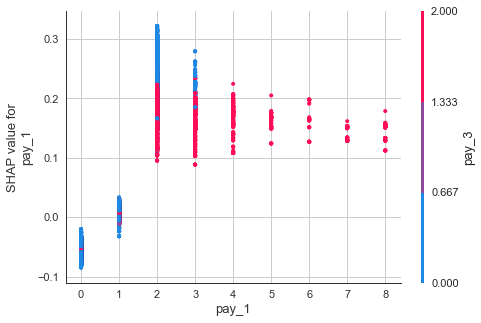

In [299]:
shap.dependence_plot("pay_1", shap_values, x_train)

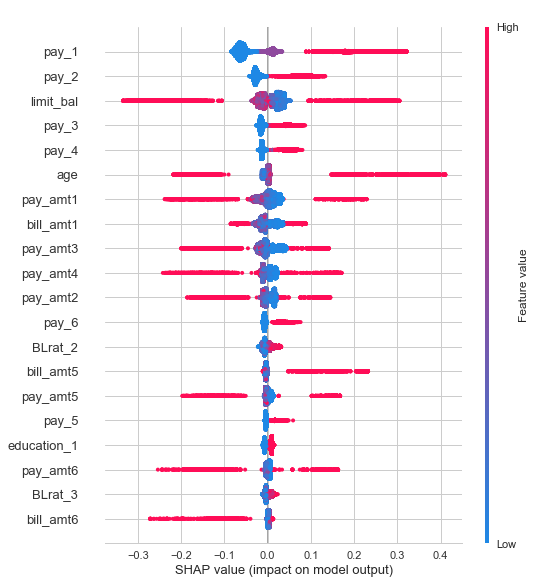

In [300]:
shap.summary_plot(shap_values, x_train)

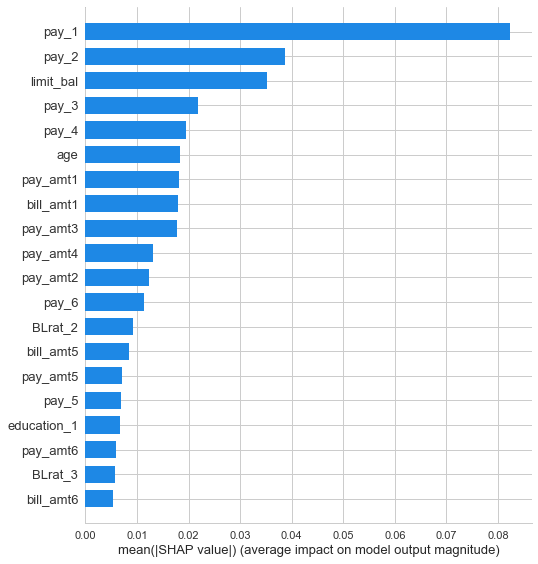

In [301]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [323]:
pd.options.display.float_format = '{:.5f}'.format
pd.DataFrame(shap_values,columns=x_train.columns).abs().mean().to_frame(name='mean').sort_values(by='mean',ascending=False)

,mean
pay_1,0.08241
pay_2,0.03863
limit_bal,0.03530
pay_3,0.02194
pay_4,0.01947
age,0.01841
pay_amt1,0.01824
bill_amt1,0.01794
pay_amt3,0.01770
pay_amt4,0.01320


In [307]:
shap_interaction_values = shap.TreeExplainer(fin_xgbm).shap_interaction_values(x_train)

In [308]:
import matplotlib.pylab as pl

In [343]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:]
tmp2 = tmp[inds,:][:,inds]

In [356]:
shaplst = tmp2.tolist()
shaplst_values = []
for lst in range(len(shaplst)):
    shaplst_values.extend(shaplst[lst])
shaplst_values.sort(reverse=True)

In [392]:
shap_top10 = shaplst_values[:20:2]

In [396]:
shapcolumns = x_train.columns.values.tolist()

In [401]:
shapinterdf = pd.DataFrame()
for shpval in shap_top10:
    i,j = np.where(tmp2 == shpval)
    shapinterdf.loc[f'{shapcolumns[i[0]]} : {shapcolumns[j[0]]}','SHAP interaction value'] = shpval
shapinterdf

,SHAP interaction value
limit_bal : age,293.21619
pay_1 : limit_bal,218.26680
limit_bal : pay_4,154.04712
pay_1 : marriage,138.23247
marriage : limit_bal,132.25066
limit_bal : bill_amt2,121.27495
pay_2 : limit_bal,108.83257
pay_3 : marriage,108.47607
limit_bal : pay_5,108.46884
limit_bal : bill_amt3,106.76289
